In [11]:
%load_ext autoreload
%autoreload 2
import importlib

import sys
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
sys.path.append('/mnt/c/MyPrograms/__github/Stabilized_ICA')
sys.path.append('/mnt/c/MyPrograms/__github/scycle/')
#print(sys.path)

import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scycle as cc
import scvelo as sv
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from elpigraph_ps_tools import *
from sica.base import StabilizedICA
import pandas as pd
import elpigraph

from scycle.preprocess import quality_control, prep_pooling
from scycle.tools import dimensionality_reduction, enrich_components, principal_circle

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy
viridis = cm.get_cmap('viridis', 100)


def renormalize_matrix_by_partition(gexp, partition):
    prt = partition
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    for p in range(npart):
        sidx = np.where(partition == p)[0] # sample index
        totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
        median = np.median(totals) # median counts for samples in group
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * median
    return new_gexp
    

def renormalize_by_partition_simplified(adata, partition, verbose = True):
    old_totals = adata.obs['total_counts']
    adata.X = renormalize_matrix_by_partition(adata.X, partition)
    if 'matrix' in adata.layers:
        adata.layers['matrix'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['matrix']),partition)
    if 'spliced' in adata.layers:
        adata.layers['spliced'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['spliced']),partition)
    if 'unspliced' in adata.layers:
        adata.layers['unspliced'] = renormalize_matrix_by_partition(_get_nd_array(adata.layers['unspliced']),partition)
    adata.obs['total_counts'] = np.sum(adata.X, axis = 1)
    adata.obs['total_counts_raw'] = old_totals

    
def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def _smooth_adata_by_pooling(adata, X_embed, n_neighbours=10, copy=False):
    # adata_pooled = adata.copy if copy else adata
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)
    adata.X = _smooth_matrix_by_pooling(_get_nd_array(adata.X), indices)
    if "matrix" in adata.layers:
        adata.layers["matrix"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["matrix"]), indices
        )
    if "spliced" in adata.layers:
        adata.layers["spliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["spliced"]), indices
        )
    if "unspliced" in adata.layers:
        adata.layers["unspliced"] = _smooth_matrix_by_pooling(
            _get_nd_array(adata.layers["unspliced"]), indices
        )

    adata.uns["scycle"] = True


def _smooth_matrix_by_pooling(matrix, indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i, :] = np.mean(matrix[indices[i], :], axis=0)
    return matrix_pooled


def _get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 300


def compute_principal_curve_from_circle(X,n_nodes=30,Mu=0.1,Lambda=0.01, produceTree=False):
    egr = elpigraph.computeElasticPrincipalCircle(X,int(n_nodes/2),Mu=Mu)
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X**2,axis=1,keepdims=1))
    node_sizes = np.array([len(np.where(partition==i)[0]) for i in range(nodep.shape[0])])
    node_min = np.argmin(node_sizes)
    edges_open = edges.copy()
    k = 0
    starting_node = -1
    while k<edges_open.shape[0]:
        e = edges_open[k,:]
        if (e[0]==node_min)|(e[1]==node_min):
            edges_open = np.delete(edges_open,k,axis=0)
            if e[0]==node_min:
                starting_node = e[1]
        else:
            k = k+1
    nodep_open = np.delete(nodep,node_min,axis=0)
    if starting_node>node_min:
        starting_node = starting_node-1
    for e in edges_open:
        if e[0]>node_min:
            e[0]=e[0]-1
        if e[1]>node_min:
            e[1]=e[1]-1
    if produceTree:
        egrl = elpigraph.computeElasticPrincipalTree(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    else:
        egrl = elpigraph.computeElasticPrincipalCurve(X,n_nodes,InitNodePositions=nodep_open,
                                                 InitEdges=edges_open,Lambda=Lambda,Mu=Mu,
                                                 alpha=0.01,FinalEnergy='Penalized')
    return egrl, starting_node

def subtract_cell_cycle_trajectory(X,partition):
    points = range(X.shape[0])
    r2scores = []
    X1 = X[points,:]
    X_ro = np.zeros((X.shape[0],X.shape[1]))
    partition_points = partition[points]
    inds = {}
    for k in range(len(partition_points)):
        j = partition_points[k][0]
        if not j in inds:
            inds[j] = [k]
        else:
            inds[j].append(k)
    XT = X1.T
    for j in range(X1.shape[0]):
        k = partition_points[j][0]
        ind = np.array(inds[k])
        X_ro[j,:] = (XT[:,j] - np.mean(XT[:,ind],axis=1)).T
    residue_matrix = X1 - X_ro
    residues_var = np.var(residue_matrix,axis=0)
    vrs = np.var(X1,axis=0)
    r2scores = residues_var/vrs
    return X_ro, residue_matrix, r2scores

from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks


def calc_curvature(nodep,smoothing_factor=10):
    splines = []
    derivs = []
    for i in range(nodep.shape[1]):
        xv = np.linspace(0,nodep.shape[0]-1,nodep.shape[0])
        yv = nodep[:,i]
        #xv = np.array([-1]+list(xv)+[xv[-1]+1])
        #yv = np.array([2*yv[0]-yv[1]]+list(yv)+[2*yv[-1]-yv[-2]])
        #plt.plot(xv,yv,'-o')
        spline = UnivariateSpline(xv,yv,s=0,k=3)
        splines.append(spline)
        derivs.append(spline.derivative(n=2))
    n_points = nodep.shape[0]
    curv = np.zeros(nodep.shape[0])
    x = np.linspace(0,nodep.shape[0]-1,n_points)
    temp = np.zeros((n_points,nodep.shape[1]))
    print(temp.shape)
    for i in range(len(derivs)):
        temp[:,i] = derivs[i](x)
    curv = np.sqrt(np.sum(temp**2,axis=1))
    curv_spl = UnivariateSpline(x,curv,s=np.var(curv)*smoothing_factor,k=3)
    return x, curv_spl(x), splines

def find_nonproliferative_cells(adata,estimation_fraction_nonproliferating_cells=0.3, 
                                number_of_nodes=50,max_number_of_iterations = 20,
                               number_of_sigmas=3.0,Mu=1.0):
    all_markers = list(adata.uns['S-phase_genes'])+list(adata.uns['G2-M_genes'])
    Xccm = adata[:,list(set(all_markers)&set(adata.var_names))].X
    cc_score = np.array(list(np.mean(Xccm,axis=1)))

    ind_sorted_prolif = np.argsort(cc_score)
    ind_nonprolif = ind_sorted_prolif[0:int(len(adata)*estimation_fraction_nonproliferating_cells)]
    adata.obs['proliferating'] = np.empty(len(adata)).astype(np.bool)
    adata.obs['proliferating'][:] = True
    adata.obs['proliferating'][ind_nonprolif] = False
    
    sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

    fraction_nonprolif_old = estimation_fraction_nonproliferating_cells

    for i in range(max_number_of_iterations):
        X_elpigraph_training = adata.obs[['S-phase','G2-M']].to_numpy().astype(np.float64)
        u = X_elpigraph_training.copy()
        X_elpigraph_training = X_elpigraph_training[adata.obs['proliferating'],:]

        egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,
                                                      Mu=Mu,drawPCAView=False,verbose=False)
        partition, dists = elpigraph.src.core.PartitionData(X = u, NodePositions = egr[0]['NodePositions'], 
                                                                MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                                SquaredX = np.sum(u**2,axis=1,keepdims=1))
        ind_prolif = adata.obs['proliferating']
        mndist = np.mean(dists[ind_prolif])
        intervaldist = np.std(dists[ind_prolif])*number_of_sigmas
        tt1 = [not b for b in adata.obs['proliferating']]
        tt2 = [(d>mndist+intervaldist)[0] for d in dists]
        nonprolif_new = np.array(tt1) & np.array(tt2)
        adata.obs['proliferating'] = [not b for b in nonprolif_new]
        fraction_nonprolif = 1-np.sum(adata.obs['proliferating'])/len(adata)
        print('\n\n===========\nIteration',i,'Fraction of non-proliferating cells:',fraction_nonprolif,'\n==============\n\n\n')    
        if np.abs(fraction_nonprolif-fraction_nonprolif_old)<0.01:
            break
        fraction_nonprolif_old = fraction_nonprolif

def find_nonproliferative_cells_from_pt_clustering(adata,number_of_nodes=50):
    X = adata.X
    X_elpigraph_training = adata.obs[['S-phase','G2-M']].to_numpy().astype(np.float64)
    egr, starting_node = compute_principal_curve_from_circle(X_elpigraph_training,
                                                             n_nodes=number_of_nodes,
                                                             Lambda=0.0001,
                                                            produceTree=True)
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                            MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                            SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
    clusters = partition_data_by_tree_branches(X_elpigraph_training,egr[0])
    adata.obs['tree_clusters'] = clusters
    all_markers = adata.uns['S-phase_genes']+adata.uns['G2-M_genes']
    Xccm = adata[:,list(set(all_markers)&set(adata.var_names))].X
    cc_score = np.array(list(np.mean(Xccm,axis=1)))
    cluster_labels = list(set(clusters))
    cluster_prolif_levels = np.empty(cc_score.shape)
    cluster_prolif_levels_percluster = np.empty(len(cluster_labels))
    for i,clb in enumerate(cluster_labels):
        cluster_prolif_levels_percluster[i] = np.mean(cc_score[clusters==clb])
        cluster_prolif_levels[clusters==clb] = cluster_prolif_levels_percluster[i]
    adata.obs['cluster_prolif_levels'] = cluster_prolif_levels
    #sc.pl.scatter(adata,x='S-phase',y='G2-M',color='cluster_prolif_levels')
    ind_cluster_nonprolif = np.argmin(cluster_prolif_levels_percluster)
    ind_prolif = clusters!=ind_cluster_nonprolif
    adata.obs['proliferating'] = ind_prolif
    print('Fraction of non-proliferating cells:',1-np.sum(adata.obs['proliferating'])/len(adata))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#file = '../EwingSarcoma_Miller2020/CHLA9'
file = 'loom_files/CHLA9'
adata = anndata.read_loom(file+'.loom')
adata.var_names_make_unique()
#adata.remove_duplicate_cells()
adata.X = adata.X.toarray()
adata.layers["matrix"] = adata.layers["matrix"].toarray()
adata.layers["spliced"] = adata.layers["spliced"].toarray()
adata.layers["unspliced"] = adata.layers["unspliced"].toarray()
adata.obs['total_counts'] = adata.obs['TotalUMIs']
adata_orig = adata.copy()
print(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs', 'total_counts'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'


In [24]:
# pre-saved CCT-normalized and pre-processed dataset - will save time and memory if one wants to 
# start with this stage
# From here one can go directly to '# Compute principal curve (open)' cell

adata = sc.read_h5ad('CHLA9_renorm_proc.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3897 × 10001
    obs: 'TotalUMIs', 'total_counts', 'total_counts_raw', 'velocity_self_transition', 'S-phase', 'G2-M', 'G2-M-', 'Histone_IC', 'proliferating'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'G2-M_INH_genes', 'G2-M_genes', 'Histone_IC_genes', 'S-phase_genes', 'neighbors', 'pca', 'scycle', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_cc', 'X_dimRed', 'X_pca', 'X_pca_scycle', 'velocity_pca'
    varm: 'PCs', 'P_dimRed'
    layers: 'Ms', 'Mu', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'veloc

In [89]:
#-- Pre-process - for some reasons does now work well with RNA velocity!!!
# cc.pp.prep_pooling(adata)

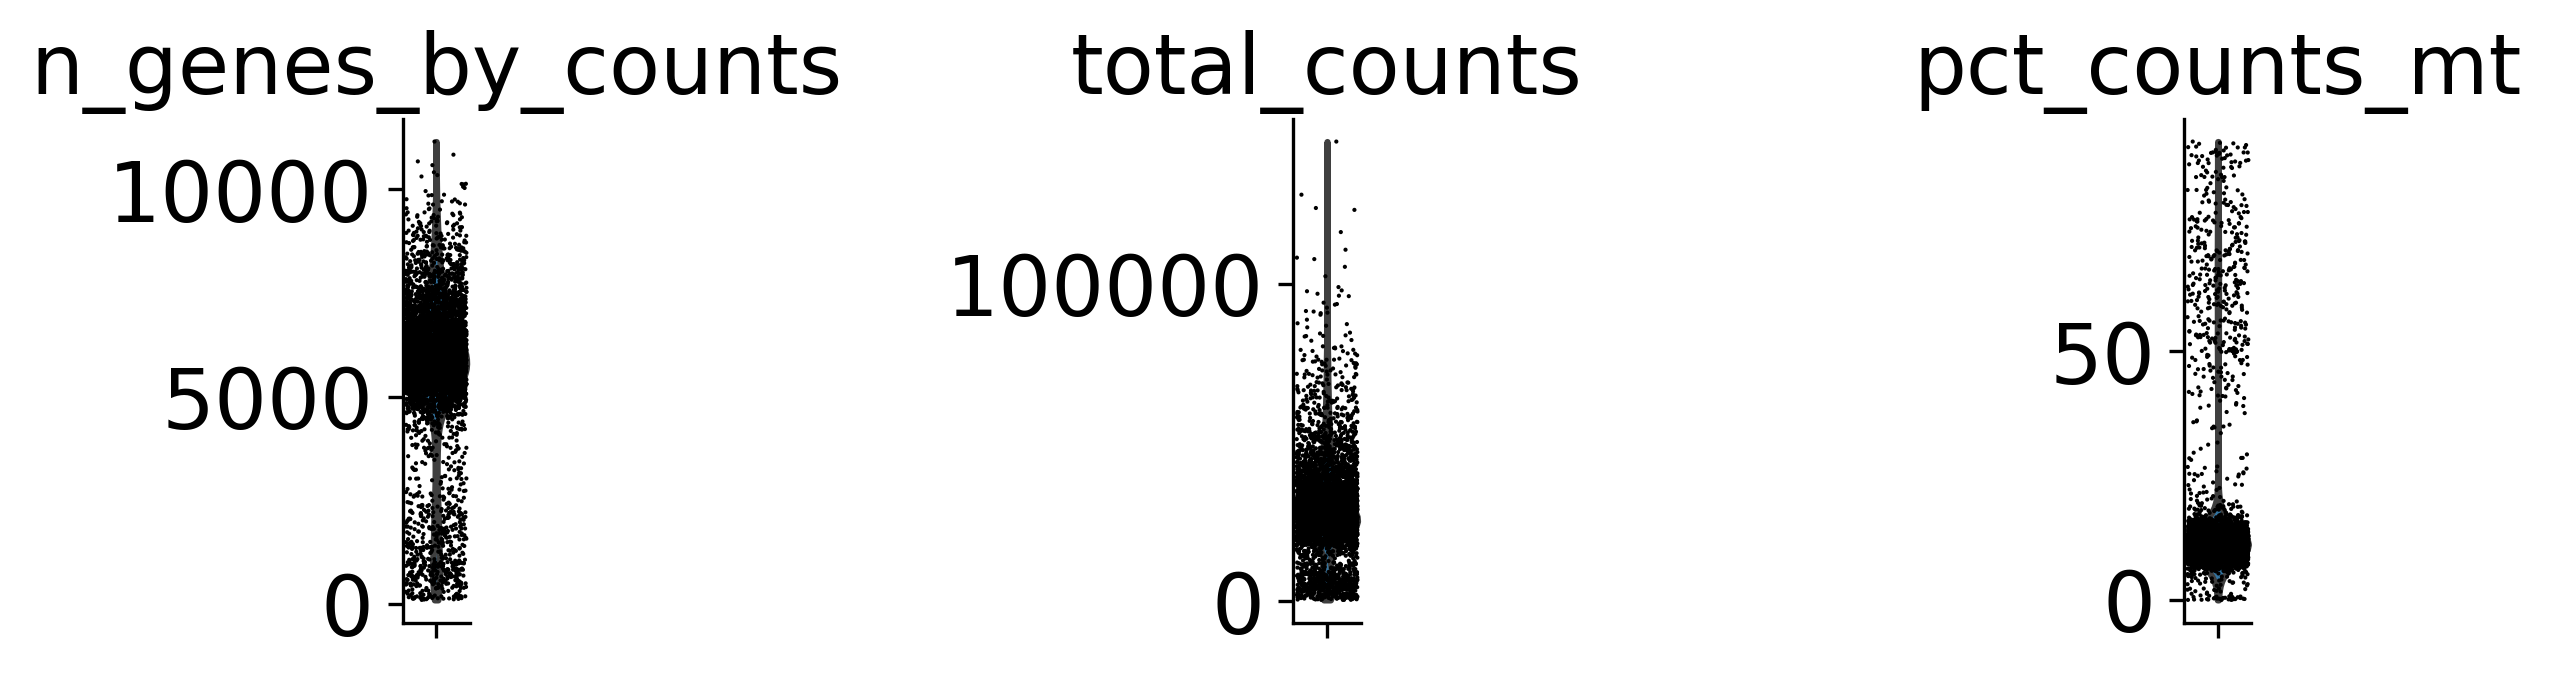

Median total counts = 27244.0


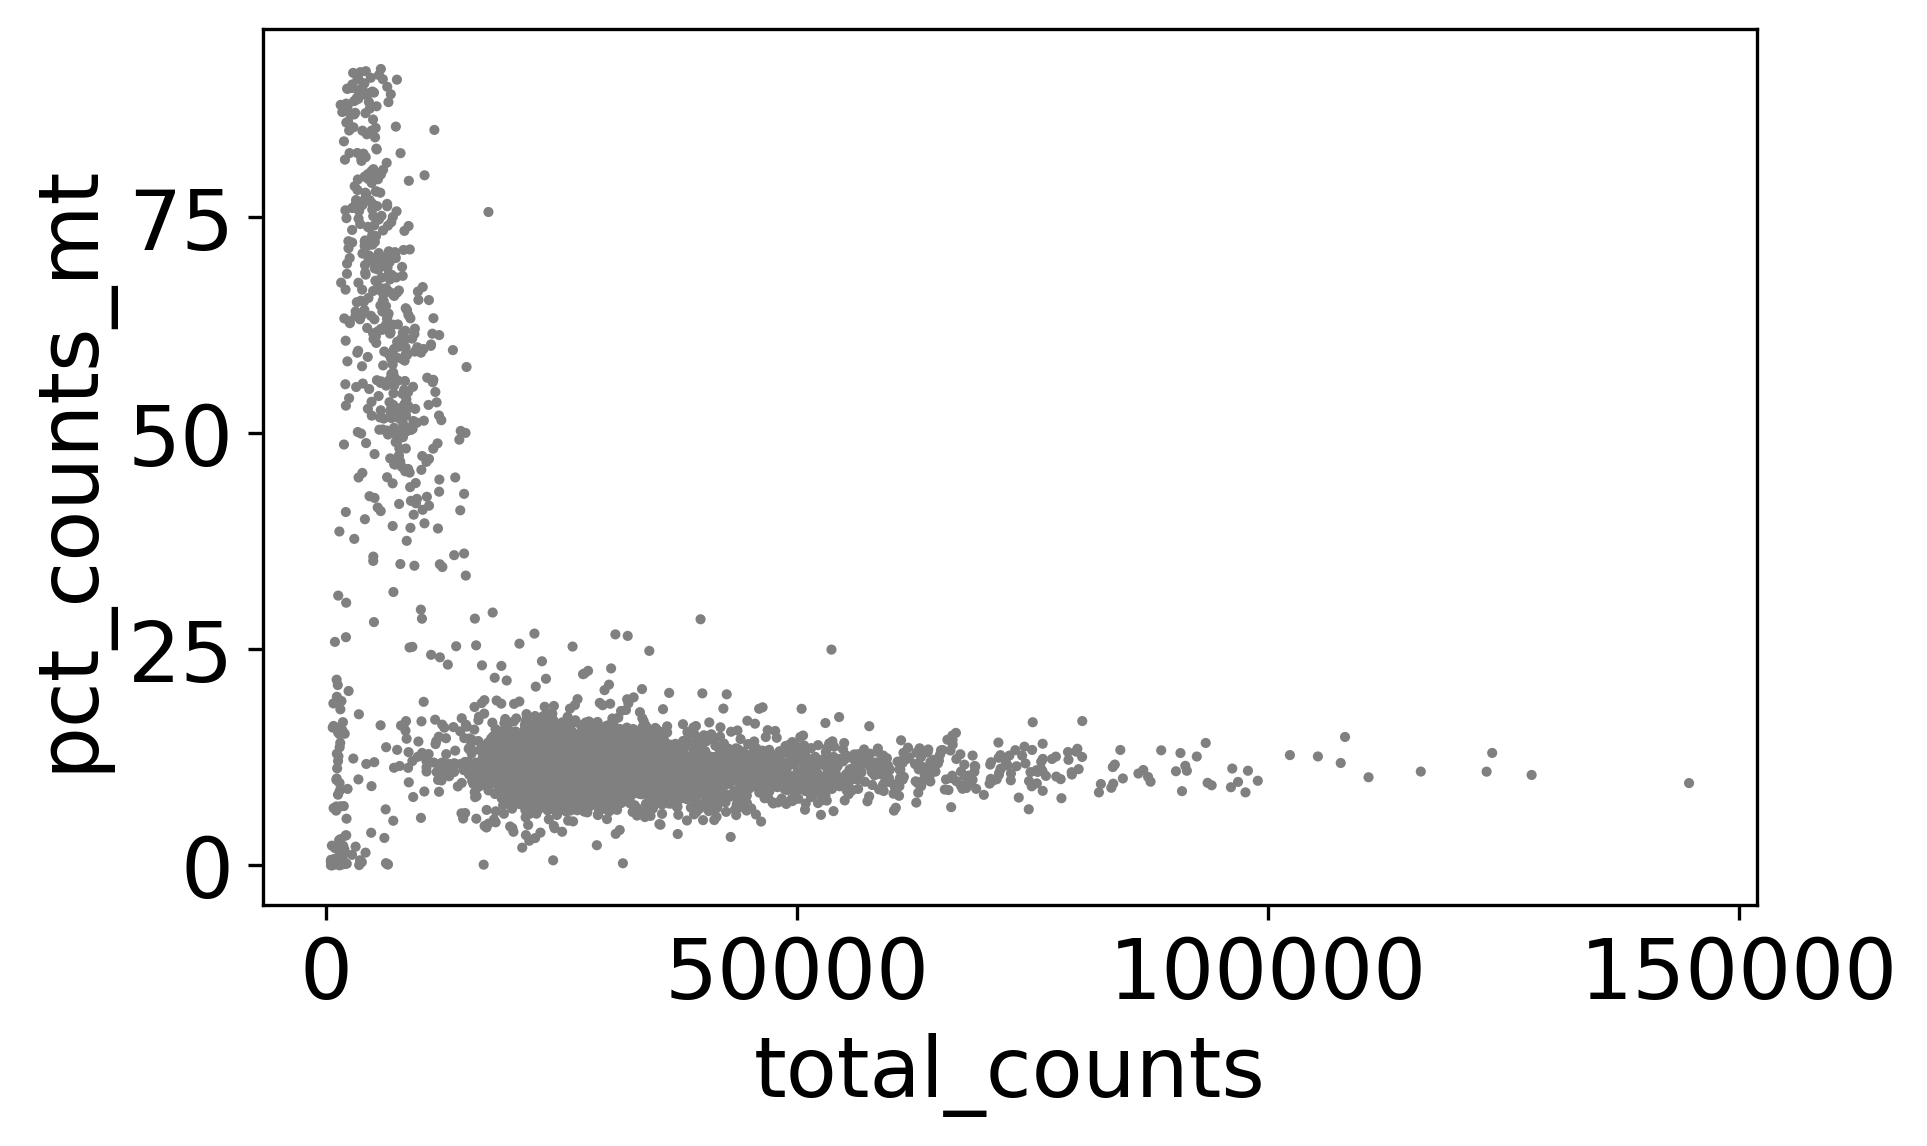

4319 samples pass the count filter
4599  samples pass the mt filter
Samples selected 4241


In [4]:
#-- Pre-process

# standard preprocessing

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

median_count = np.median(adata.obs['total_counts'])
print('Median total counts =',median_count)
min_count = np.max((median_count/2,5000))
if min_count>10000:
    min_count=10000
max_count = median_count*2

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
inds2 = np.where(adata.obs['pct_counts_mt']<20)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))

adata = adata[ind_samples,:]

sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]
sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

adata_work = adata_orig.copy()[ind_samples,:]
_smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=10)
adata = adata_work
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
adata = adata[:,ind_genes]

sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

In [25]:
sv.pp.moments(adata)
sv.tl.velocity(adata, mode='stochastic')
sv.tl.velocity_graph(adata)

computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


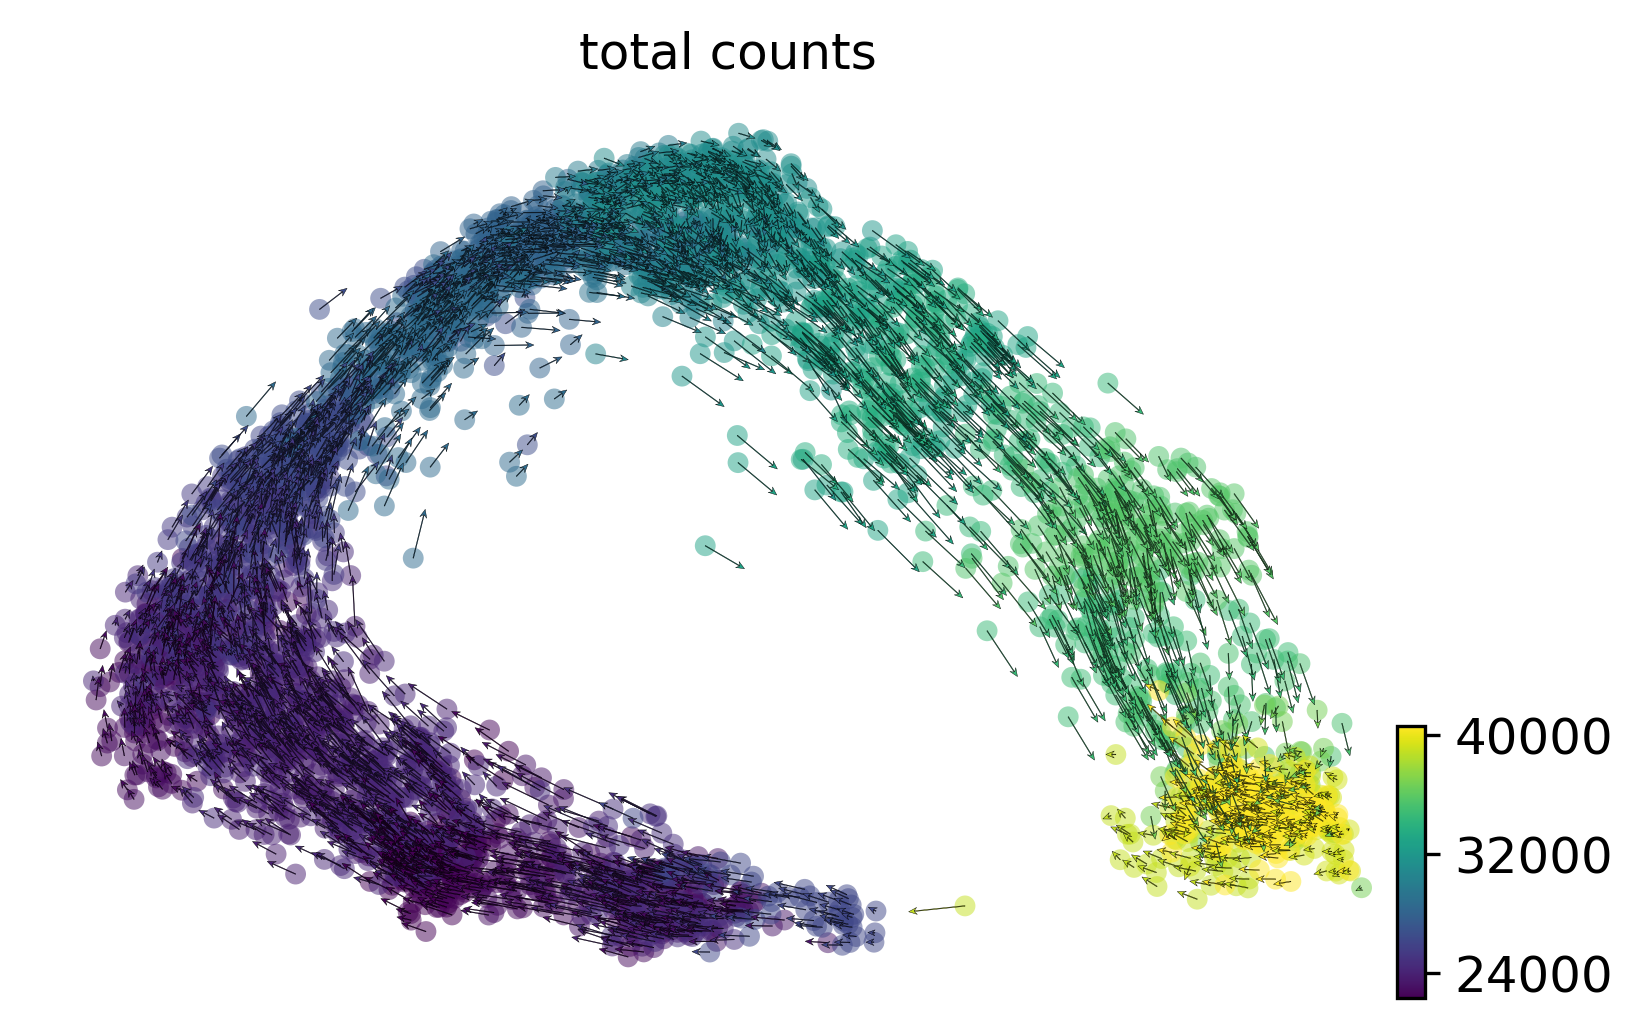

In [26]:
sv.pl.velocity_embedding(adata, basis='pca',components='1,2', color='total_counts', size=100, alpha=0.5,perc=[2,98],
                         arrow_size=1,dpi=300,arrow_length=10) 


In [19]:
adata.uns["scycle"] = {}
cc.tl.dimensionality_reduction(adata,method='ica')
cc.tl.enrich_components(adata)

idx_g1s = adata.uns['scycle']['enrich_components']['G1/S']
adata.uns['S-phase_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g1s,:]>3])
idx_g2m = adata.uns['scycle']['enrich_components']['G2/M+']
adata.uns['G2-M_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m,:]>3])
idx_g2m_inh = adata.uns['scycle']['enrich_components']['G2/M-']
adata.uns['G2-M_INH_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_g2m_inh,:]>3])
idx_histone = adata.uns['scycle']['enrich_components']['Histone']
adata.uns['Histone_IC_genes'] = list(adata.var_names[adata.uns['dimRed'].S_[idx_histone,:]>3])

signature_dict = {'S-phase':adata.uns['S-phase_genes'],
                  'G2-M':adata.uns['G2-M_genes'],
                  'G2-M-':adata.uns['G2-M_INH_genes'],
                  'Histone_IC':adata.uns['Histone_IC_genes']}  

sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]
scores_dic = calc_scores(adata2k,signature_dict)
for score in scores_dic:
    adata.obs[score] = scores_dic[score]


adata.varm['P_dimRed'] = adata.uns['dimRed'].S_.T
adata.uns['dimRed'] = None

-- Dimensionality reduction using ICA...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
FastICA from sklearn did not converge due to numerical instabilities - Retrying...
-- Done
G1/S  score: 9.267610
G2/M+ score: 10.341569
G2/M- score: 13.929934
HIST  score: 25.012917
--- Selected components:
G1/S: 1 (score=9.267610)
G2/M: 6 (score=10.341569)
G2/M-: 11 (score=13.929934)
Histones: 2 (score=25.012917)


In [31]:
#adata.write_h5ad('CHLA9_renorm_proc.h5ad',compression='gzip')

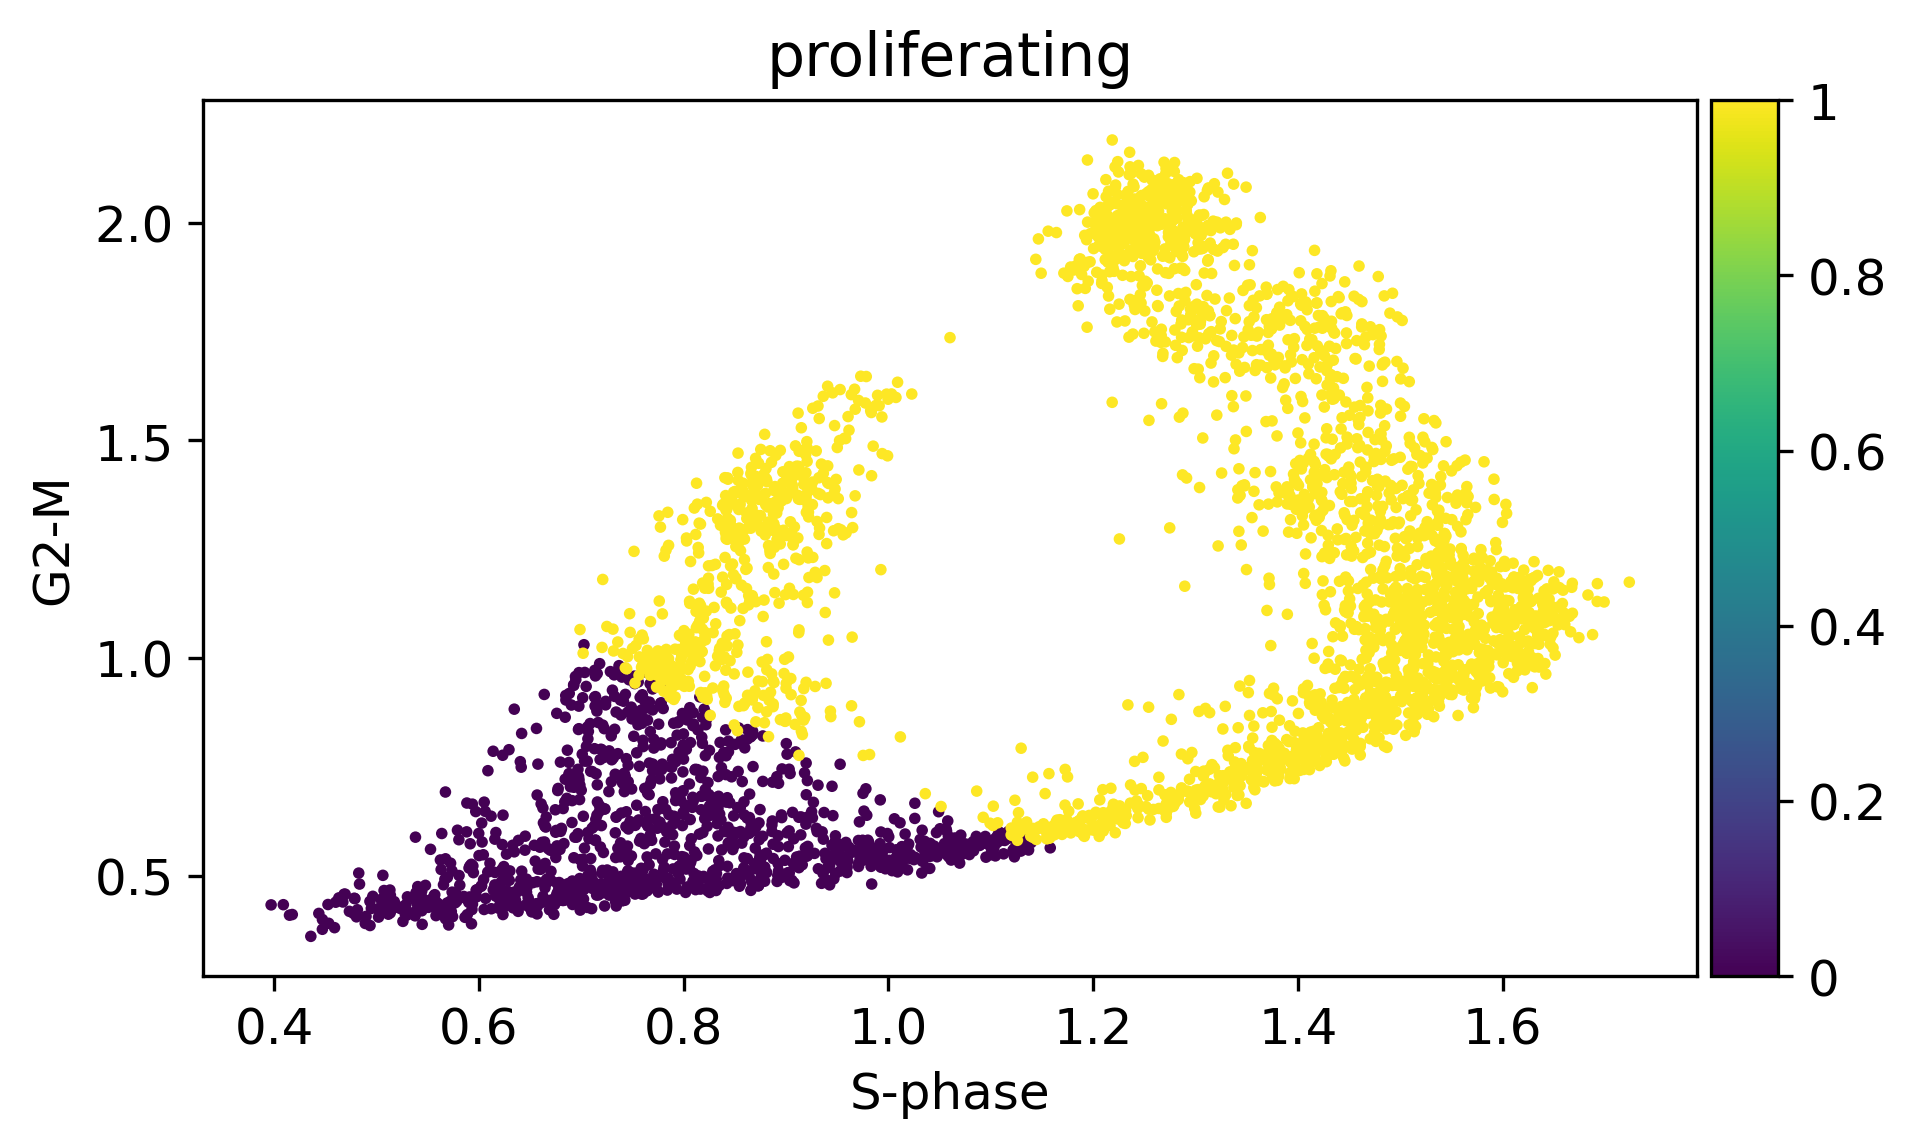

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  2728  points and  2  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	0.0067	50	50	50	0	0	0	0.0034	0.003	0.9858	0.9872	0.0022	0.0012	0.06	3.0014	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
2.4763  seconds elapsed


Iteration 0 Fraction of non-proliferat

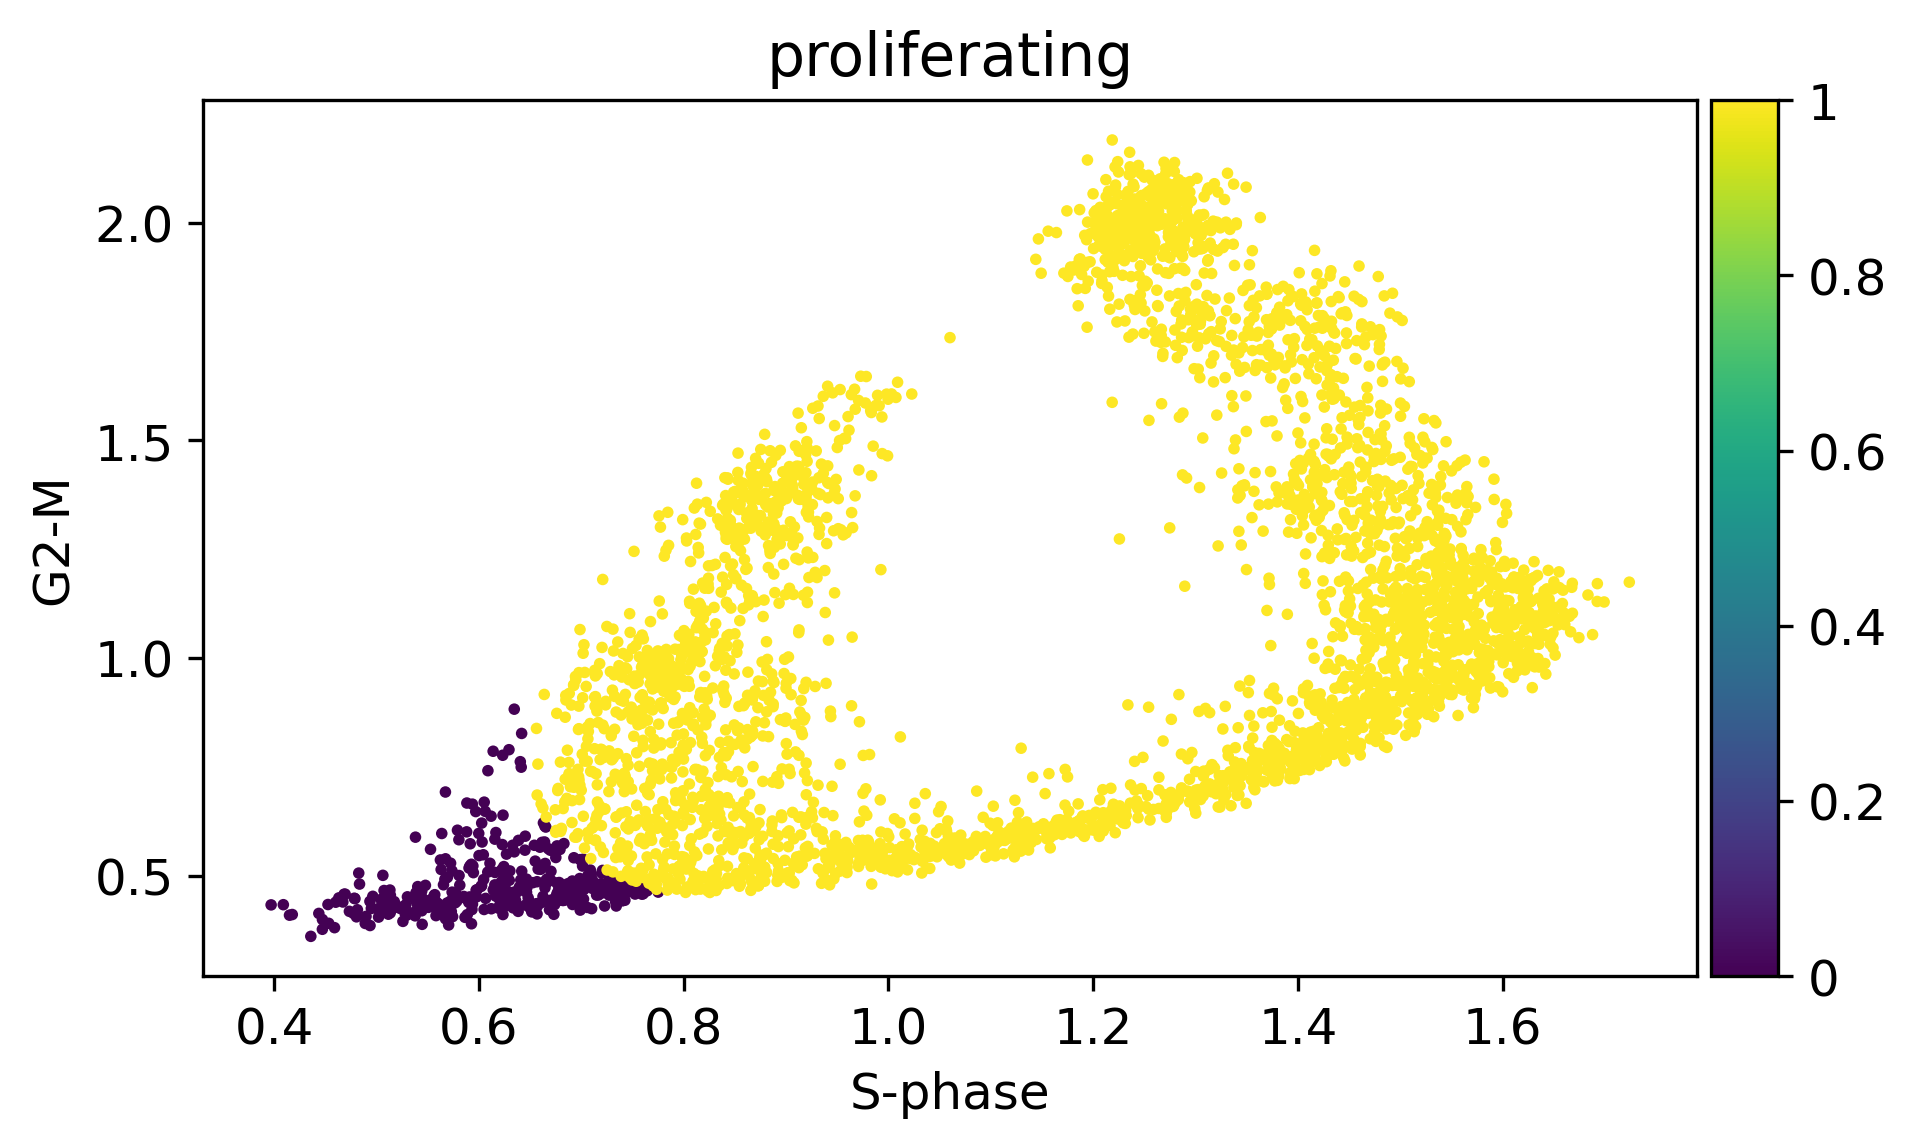

In [28]:
find_nonproliferative_cells(adata)
sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  25  nodes on  4241  points and  2  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||25	0.0093	25	25	25	0	0	0	0.0048	0.0038	0.9758	0.9809	0.0034	0.0011	0.0272	0.6796	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.505  seconds elapsed


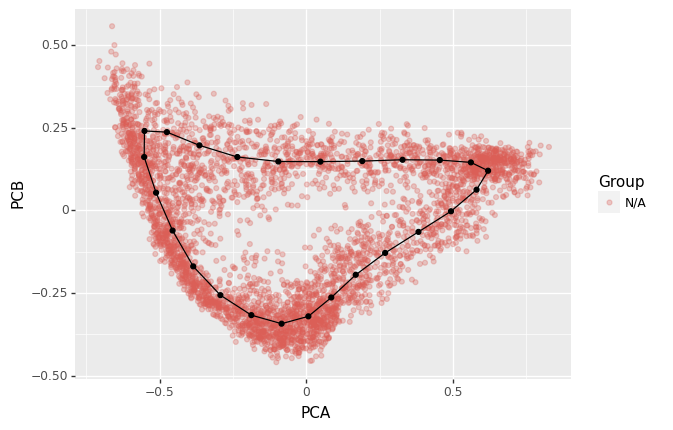

[<ggplot: (8770631091185)>]
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
2 dimensions are being used
100.0 % of the original variance has been retained
Computing EPG with  50  nodes on  4241  points and  2  dimensions
Nodes =  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50	0.0031	50	49	46	1	0	0	0.0029	0.0026	0.9852	0.9869	0.0	0.0002	0.0096	0.4785	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
15.112  seconds elapsed


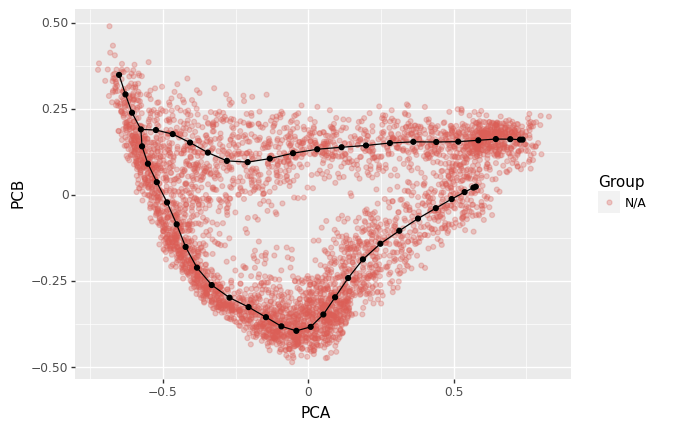

[<ggplot: (8770631215493)>]
Fraction of non-proliferating cells: 0.03466163640650788


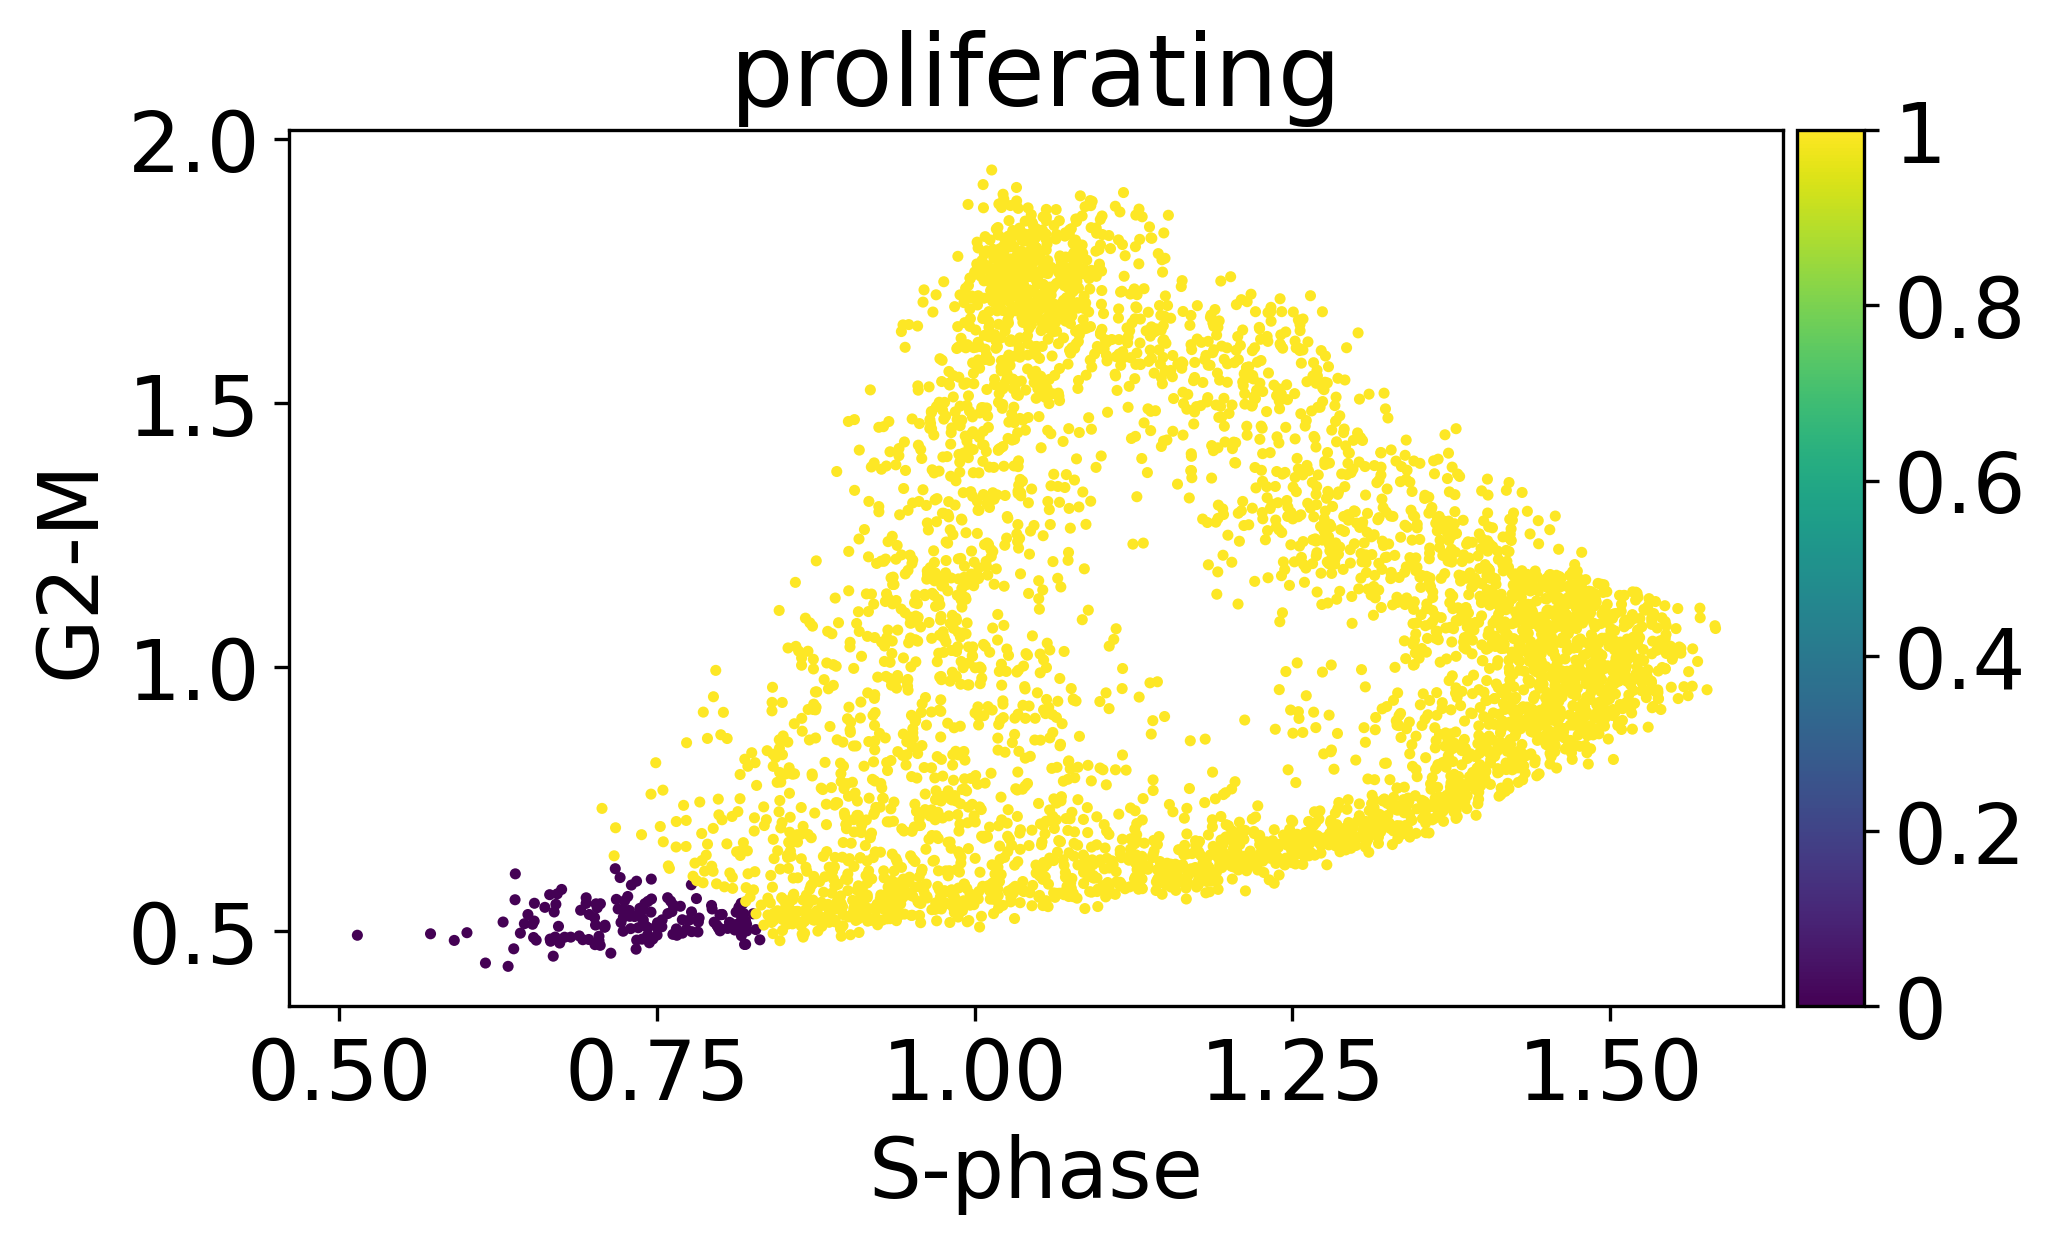

In [10]:
find_nonproliferative_cells_from_pt_clustering(adata)
sc.pl.scatter(adata,x='S-phase',y='G2-M',color='proliferating')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  4062  points and  30  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	18.6278	50	50	50	0	0	0	17.125	16.9985	0.7937	0.7952	0.9273	0.5754	28.7724	1438.621	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
4.9842  seconds elapsed


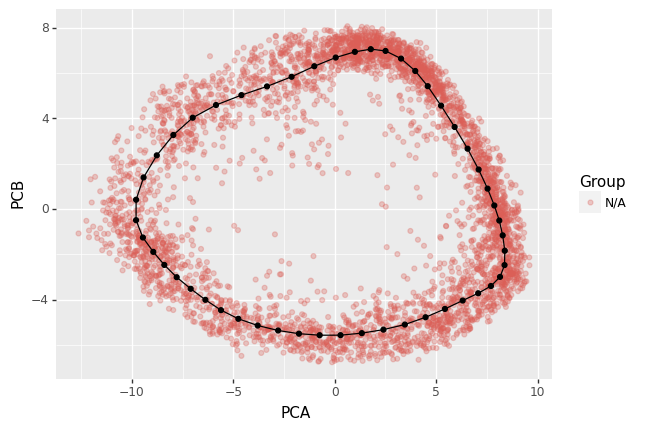

[<ggplot: (8770631160829)>]


In [12]:
# Compute principal circle

import elpigraph

X = adata.X
X_prolif = adata.X[adata.obs['proliferating'],:]

number_of_nodes=50

mn_prolif = np.mean(X_prolif,axis=0)
pca = PCA(n_components=30)
u = pca.fit_transform(X_prolif)
v = pca.components_.T
#X_pca = adata.obsm['X_pca'].astype(np.float64)
X_elpigraph_training = u.astype(np.float64)
egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,number_of_nodes,Mu=0.2)
partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
Xp = (X-mn_prolif)@v
partition, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(Xp**2,axis=1,keepdims=1))


nodep = egr[0]['NodePositions']
edges = egr[0]['Edges'][0]


The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  25  nodes on  3519  points and  30  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||25	22.6055	25	25	25	0	0	0	18.9158	18.4546	0.8186	0.823	1.7408	1.9489	48.7221	1218.0516	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
1.0073  seconds elapsed


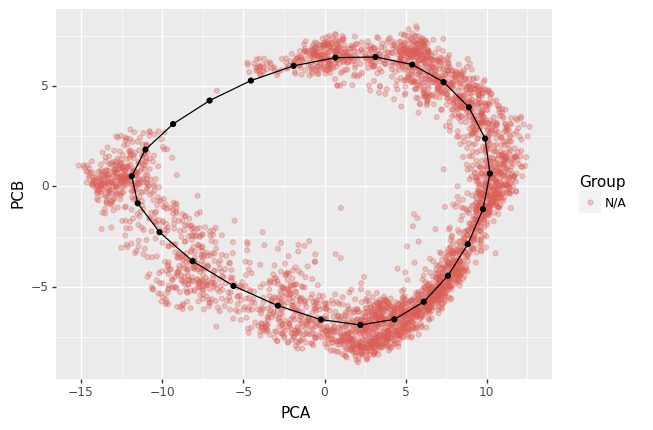

[<ggplot: (8739159491765)>]
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
Computing EPG with  50  nodes on  3519  points and  30  dimensions
Nodes =  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	17.2653	50	49	48	0	0	0	16.4614	16.3161	0.8421	0.8435	0.001	0.803	40.1483	2007.4175	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
3.9846  seconds elapsed


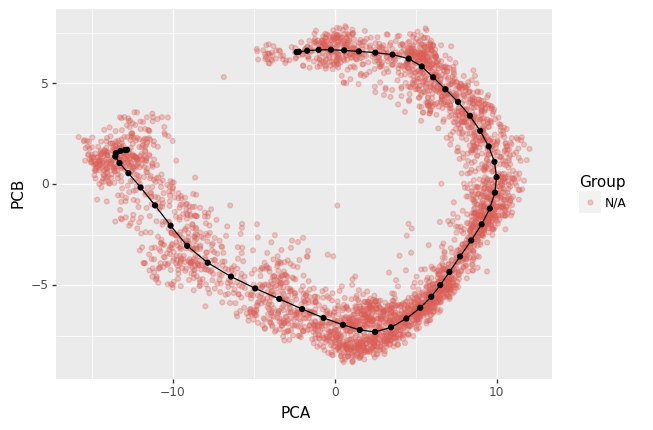

[<ggplot: (8739159483037)>]


In [29]:
# Compute principal curve (open)
# Skip this step if you work with global library size normalization

import elpigraph

X = adata.X
X_prolif = adata.X[adata.obs['proliferating'],:]

number_of_nodes=50

mn_prolif = np.mean(X_prolif,axis=0)
pca = PCA(n_components=30)
u = pca.fit_transform(X_prolif)
v = pca.components_.T
#X_pca = adata.obsm['X_pca'].astype(np.float64)
X_elpigraph_training = u.astype(np.float64)

egr, starting_node = compute_principal_curve_from_circle(X_elpigraph_training,
                                                         n_nodes=number_of_nodes,
                                                        produceTree=False,Mu=0.3,Lambda=0.00001)

partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
Xp = (X-mn_prolif)@v
partition, dists = elpigraph.src.core.PartitionData(X = Xp, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(Xp**2,axis=1,keepdims=1))

nodep = egr[0]['NodePositions']
edges = egr[0]['Edges'][0]


Cell cycle genes initially found: 593
Top ones: ['CDCA8', 'CDC20', 'KIF2C', 'NUF2', 'ASPM', 'CENPA', 'TACC3', 'NCAPG', 'CENPE', 'HMGB2', 'CCNB1', 'KIF20A', 'HMMR', 'H4C3', 'H1-3', 'H1-5', 'KIFC1', 'CKS2', 'CDK1', 'CDCA3', 'NUSAP1', 'PIF1', 'AC027237.1', 'PLK1', 'AURKB', 'TOP2A', 'KPNA2', 'NDC80', 'TPX2', 'UBE2C', 'AURKA']


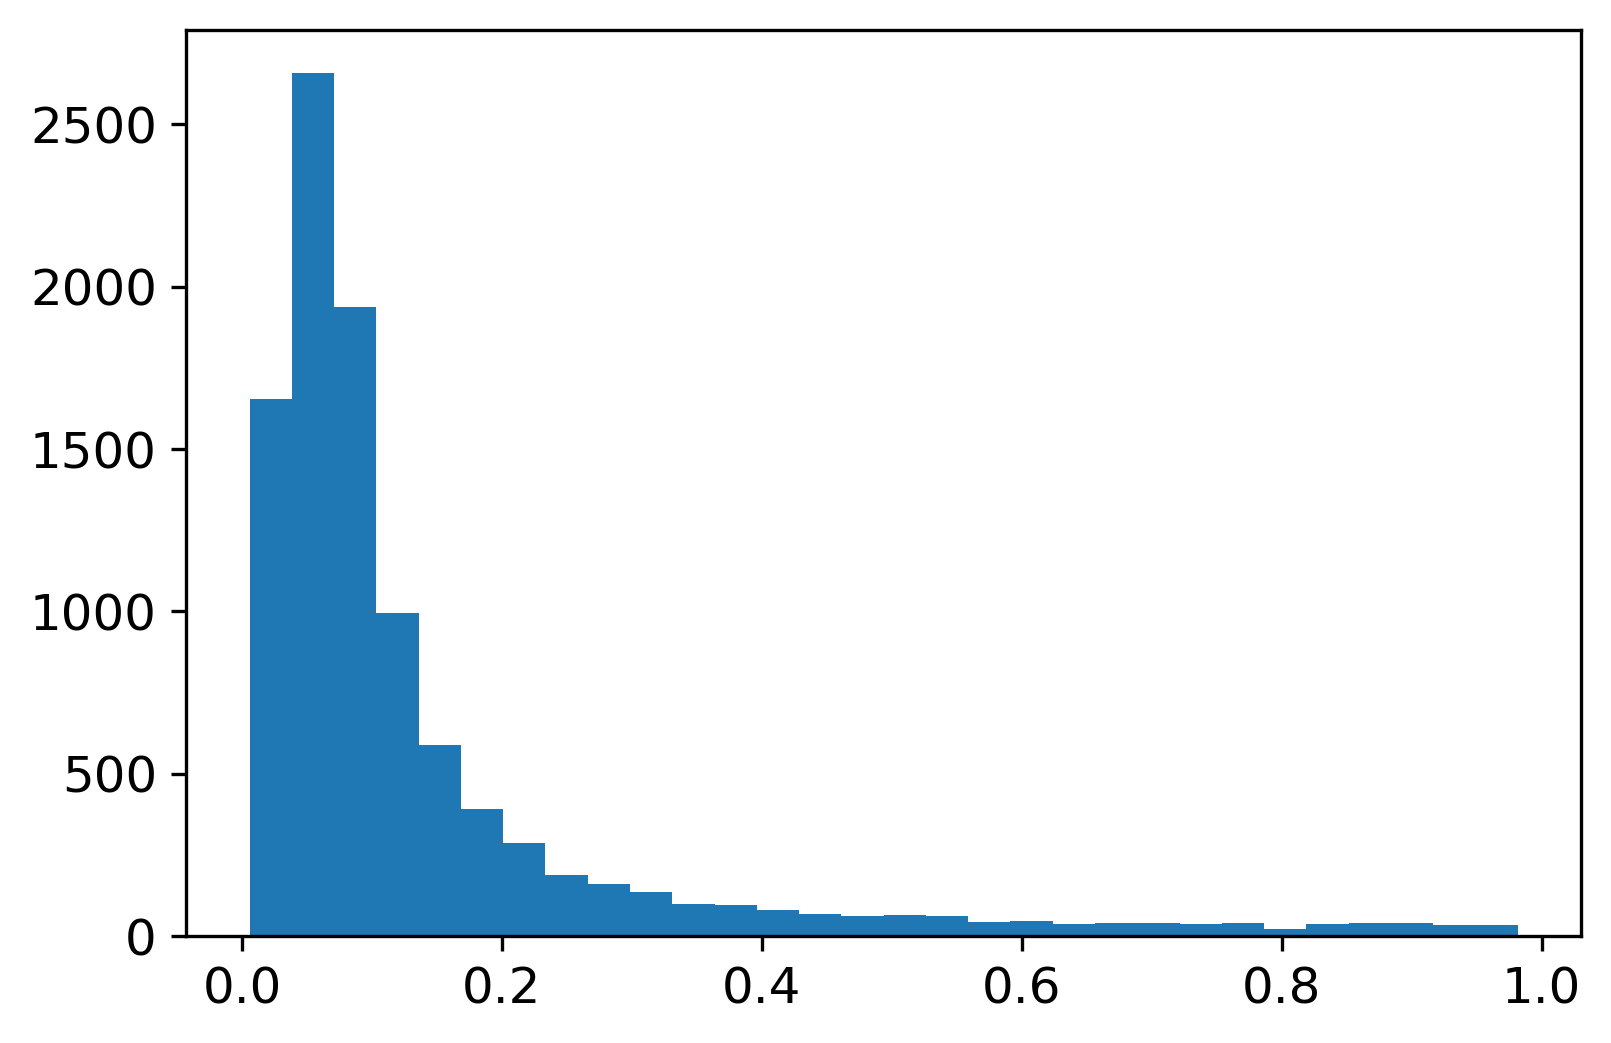

In [30]:
# Compute self-consistent principal curve

r2_threshold = 0.5
#X_ro, residue_matrix, r2scores = subtract_cell_cycle_trajectory(adata.X,partition)
adata.obs['partition'] = partition
Xtemp = adata.X
cc.tl.subtract_cc(adata)
adata.X = Xtemp
r2scores = adata.var['r2_scores']
plt.hist(r2scores,bins=30)
ind = np.where(r2scores>r2_threshold)[0]
print('Cell cycle genes initially found:',len(ind))
print('Top ones:',list(adata.var_names[np.where(r2scores>0.95)[0]]))
adata.uns['cc_genes'] = list(adata.var_names[ind])


doComputeSelfConsistentCCT = False

if doComputeSelfConsistentCCT:
    number_of_pc_components = 30
    max_number_of_iterations = 10
    eps_jaccard = 0.01
    ind_old = ind
    for counter in range(max_number_of_iterations):
        Xcc = adata.X[:,ind]
        pca = PCA(n_components=number_of_pc_components)
        Xcc_reduced = pca.fit_transform(Xcc)
        mn = np.mean(Xcc,axis=0)
        u = Xcc_reduced
        v = pca.components_.T

        #egr_sc, pst_sc, points_sc, partition_sc, traj_sc = compute_trajectory(Xcc_reduced.astype(np.float64),total_counts,
        #                                                 mu=mu,number_of_nodes=number_of_nodes)
        #X_ro_sc, residue_matrix_sc, r2scores_sc = subtract_cell_cycle_trajectory(adata.X,partition_sc)
        
        Xr = Xcc_reduced.astype(np.float64)
        
        egr, starting_node = compute_principal_curve_from_circle(Xr,
                                                                 n_nodes=number_of_nodes)
        nodep = egr[0]['NodePositions']
        edges = egr[0]['Edges'][0]
        partition, dists = elpigraph.src.core.PartitionData(X = Xr, NodePositions = nodep, 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(Xr**2,axis=1,keepdims=1))        
        adata.obs['partition'] = partition
        Xtemp = adata.X
        cc.tl.subtract_cc(adata)
        adata.X = Xtemp
        r2scores_sc = adata.var['r2_scores']
        
        ind = np.where(r2scores_sc>r2_threshold)[0]
        idx_common_genes = list(set(ind)&set(ind_old))
        union_genes = list(set(ind)|set(ind_old))
        perc = len(idx_common_genes)/len(union_genes)
        print('\n\nIteration',counter+1,'==================\nJaccard coeff:',perc,'Old:',len(ind_old),'New:',len(ind),'\n==================\n')
        if perc>1-eps_jaccard:
            break
        ind_old = ind.copy()
        
    print('Cell cycle genes found from the self-consistent trajectory:',len(ind))
    print('Top ones:',list(adata.var_names[np.where(r2scores>0.9)[0]]))
    adata = adata[:,ind]
    Xcc = adata.X
    pca = PCA(n_components=number_of_pc_components)
    Xcc_reduced = pca.fit_transform(Xcc)
    mn = np.mean(Xcc,axis=0)
    u = Xcc_reduced
    v = pca.components_.T
    


In [23]:
delta = 0.05

tc_name = 'total_counts_raw'
if not tc_name in adata.obs:
    tc_name = 'total_counts'
tc = adata.obs[tc_name]
tc = scipy.stats.mstats.winsorize(tc,limits=[0.1,0.1])
tc = (tc-np.min(tc))/(np.max(tc)-np.min(tc))*100

velocity_X = adata.layers['velocity']

mean_vector = np.mean(X_elpigraph_training,axis=0)
nodep_full = np.matmul(v,nodep.T).T+mn_prolif
adata.uns['NodePositions'] = nodep_full
adata.uns['Edges'] = edges
adata.obs['partition'] = partition
print(nodep_full.shape)

mn1 = np.mean(adata.X,axis=0)
pca = PCA(n_components=30)
u1 = pca.fit_transform(adata.X)
v1 = pca.components_.T

nodep1 = np.matmul(nodep_full-mn1,v1)

xx = np.matmul(velocity_X,v1)
n = adata.X.shape[0]
fig = plt.figure(figsize=(7.5,6.1))
ax = fig.add_subplot(1,1,1)
plt.scatter(u1[0:n,0],u1[0:n,1],c=adata.obs[tc_name],s=1)
#plt.scatter(u[0:n,0],u[0:n,1],c='k',s=1)
for i in range(n):
    x1 = u1[i,0:2]
    x2 = xx[i,0:2]*delta
    if adata.obs['proliferating'][i]:
        plt.arrow(x1[0],x1[1],x2[0],x2[1],width=0.07,color=viridis(int(tc[i])),edgecolor=(0,0,0))
    else:
        plt.arrow(x1[0],x1[1],x2[0],x2[1],width=0.07,color='grey',edgecolor=(0,0,0))
plt.xlabel('PC1',fontsize=15)
plt.ylabel('PC2',fontsize=15)
#plt.axis('equal')
plt.colorbar()
#plt.axis('off')
#ax.get_xaxis().set_ticks([])
#ax.get_yaxis().set_ticks([])
for e in edges:
    plt.plot([nodep1[e[0],0],nodep1[e[1],0]],[nodep1[e[0],1],nodep1[e[1],1]],'r-',linewidth=10)
plt.savefig('CHLA9_PCA.png')
plt.show()

#plt.scatter(u[0:n,0],u[0:n,1],c=adata[:,'MKI67'].X,s=1)

ValueError: operands could not be broadcast together with shapes (50,591) (10001,) 

(3897, 2)


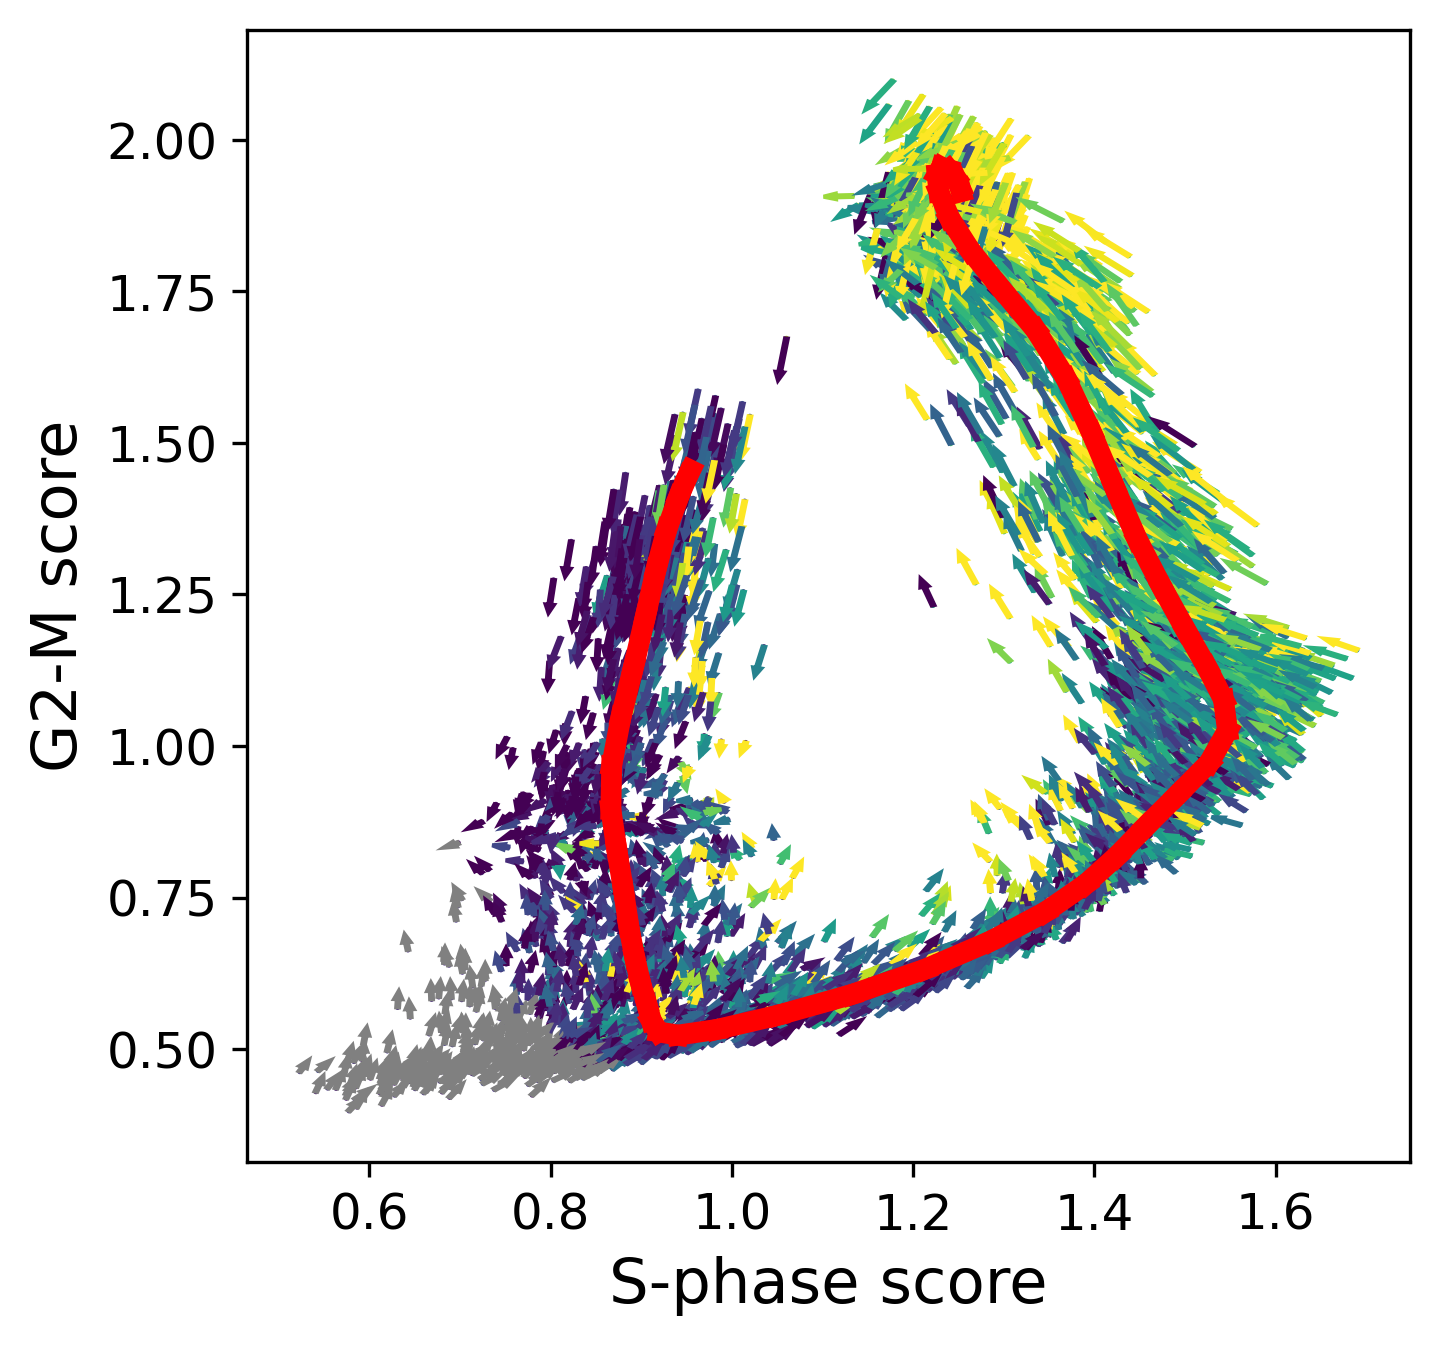

In [12]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
X = adata.X

delta=0.05
mn = mn_prolif

tc_name = 'total_counts_raw'
if not tc_name in adata.obs:
    tc_name = 'total_counts'
tc = adata.obs[tc_name]
tc = scipy.stats.mstats.winsorize(tc,limits=[0.1,0.1])
tc = (tc-np.min(tc))/(np.max(tc)-np.min(tc))*100
velocity_X = adata.layers['velocity']

X1 = X + velocity_X*delta*1
X2 = np.concatenate((X,X1),axis=0)
adata_temp = anndata.AnnData(X = X2)
adata_temp.obs_names = list(adata.obs_names)*2
adata_temp.var_names = adata.var_names
adata_temp.obs['total_counts'] = list(adata.obs['total_counts'])*2

sc.pp.highly_variable_genes(adata_temp,n_top_genes=2001,n_bins=20)
#ind_genes2k = np.where(adata_temp.var['highly_variable'])[0]
#adata2k = adata_temp[:,ind_genes2k]
scores_dic = calc_scores(adata_temp,signature_dict)
for s in scores_dic:
    adata_temp.obs[s] = scores_dic[s]

n = X.shape[0]

x1 = adata_temp.obs[['S-phase','G2-M']].to_numpy()[0:n]
print(x1.shape)
x2 = adata_temp.obs[['S-phase','G2-M']].to_numpy()[n:2*n]

n_nodes = nodep.shape[0]
nodes_projection = np.zeros((n_nodes,2))
node_real_coordinates = nodep@v.T+mn

adata_nodes = anndata.AnnData(X = node_real_coordinates)
adata_nodes.var_names = adata.var_names
scores_dic_nodes = calc_scores(adata_nodes,signature_dict)
for s in scores_dic_nodes:
    adata_nodes.obs[s] = scores_dic_nodes[s]

for i in range(n_nodes):
    nodes_projection[i,:] = np.mean(x1[np.where(partition==i)[0],:],axis=0)
    
#cc.pp.score_cell_cycle(adata_temp)
ax = fig.add_subplot(1,1,1)
ax.scatter(x1[:,0],x1[:,1],c=adata.obs['total_counts'],s=0.1)

#plt.scatter(x1[:,0],x1[:,1],c='k',s=1)
#plt.scatter(x2[:,0],x2[:,1],c='b',s=1)

for i in range(n):
    p1 = x1[i,:]
    p2 = x2[i,:]-x1[i,:]
    if adata.obs['proliferating'][i]:
        plt.arrow(p1[0],p1[1],p2[0],p2[1],width=0.003,color=viridis(int(tc[i])),edgecolor=None)
    else:
        plt.arrow(p1[0],p1[1],p2[0],p2[1],width=0.003,color='grey',edgecolor=None)
    #plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k-')
plt.xlabel('S-phase score',fontsize=15)
plt.ylabel('G2-M score',fontsize=15)
node_scores = adata_nodes.obs[['S-phase','G2-M']].to_numpy()
for e in edges:
    #plt.plot([nodes_projection[e[0],0],nodes_projection[e[1],0]],
    #         [nodes_projection[e[0],1],nodes_projection[e[1],1]],'b-',linewidth=10)
    plt.plot([node_scores[e[0],0],node_scores[e[1],0]],
             [node_scores[e[0],1],node_scores[e[1],1]],'r-',linewidth=5)
    
#plt.axis('equal')
#plt.axis('off')
#plt.axis(fontsize=20)
#ax.xaxis.get_major_ticks().label.set_fontsize(20) 
plt.savefig('CHLA9_G1S_G2M.png')
plt.show()

In [37]:
#adata.write_h5ad('CHLA9_proc.h5ad',compression='gzip')

In [1]:
# renormalization of library size, skip this and next two cells if you already work 
# with renormalized dataset

adata_renorm = adata_orig.copy()[ind_samples,:]
renormalize_by_partition_simplified(adata_renorm,partition)
adata_renorm_proc = adata_renorm.copy()
sc.pp.calculate_qc_metrics(adata_renorm_proc, percent_top=None, log1p=False, inplace=True)
sc.pp.log1p(adata_renorm_proc)
adata_renorm_proc = adata_renorm_proc[:,ind_genes]
sc.tl.pca(adata_renorm_proc,n_comps=30)
X_pca = adata_renorm_proc.obsm['X_pca']
adata_work = adata_renorm.copy()
_smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=10)
adata_renorm_proc = adata_work
sc.pp.log1p(adata_renorm_proc)
adata_renorm_proc = adata_renorm_proc[:,ind_genes]
sc.tl.pca(adata_renorm_proc,n_comps=30)
X_pca = adata_renorm_proc.obsm['X_pca']

NameError: name 'adata_orig' is not defined

In [40]:
# To make the analyses for the renormalized dataset, go to the cell  "Compute principal curve (open)""
adata = adata_renorm_proc

In [39]:
# saving the renormalized datasets
adata_renorm.write_h5ad('CHLA9_renorm.h5ad',compression='gzip')
adata_renorm_proc.write_h5ad('CHLA9_renorm_proc.h5ad',compression='gzip')

... storing 'Accession' as categorical
... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical
... storing 'Aliases' as categorica

[21, 18, 2, 33, 47, 43, 37, 12, 8, 4, 14, 27, 30, 39, 26, 48, 49, 40, 28, 16, 24, 20, 6, 11, 1, 29, 36, 44, 25, 0, 22, 19, 15, 9, 41, 45, 35, 32, 13, 23, 5, 17, 34, 38, 46, 42, 31, 3, 10, 7]


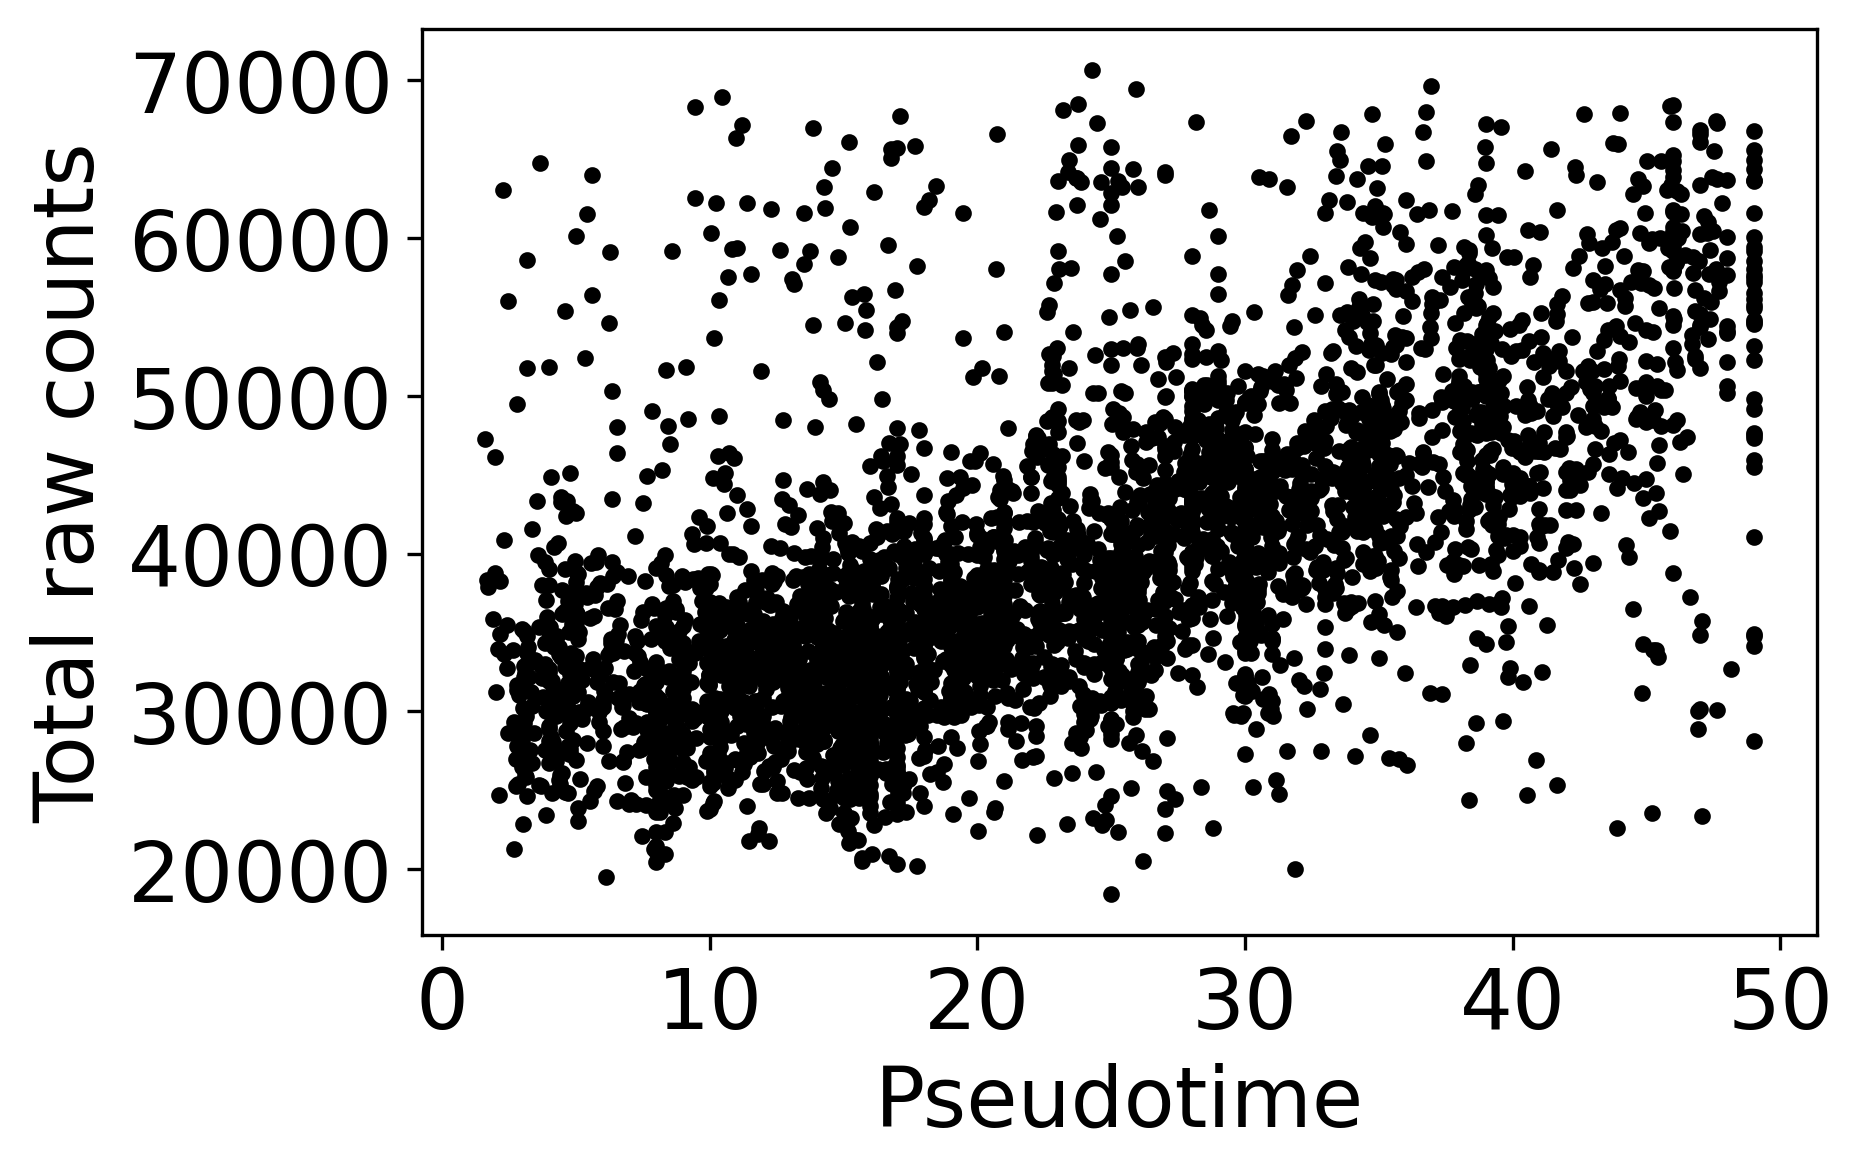

In [73]:
# Compute pseudo-time

gr = egr[0]
#starting_node = 23
traj = extract_trajectories(gr,starting_node,verbose=False)[0]
print(traj)
ProjStruct = project_on_tree(Xp,gr)
PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
points = PseudoTimeTraj[0]['Points'] 
pst = PseudoTimeTraj[0]['Pseudotime']

tcr = np.array(adata.obs['total_counts_raw'])
corr = np.corrcoef(pst,tcr[points])[0,1]
if corr<0:
    traj.reverse()
    PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
    points = PseudoTimeTraj[0]['Points'] 
    pst = PseudoTimeTraj[0]['Pseudotime']

skip_borders = 50
pstc = pst[skip_borders:-skip_borders]
pointsc = points[skip_borders:-skip_borders]
plt.plot(pstc,tcr[pointsc],'k.')
plt.xlabel('Pseudotime',fontsize=20)
plt.ylabel('Total raw counts',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

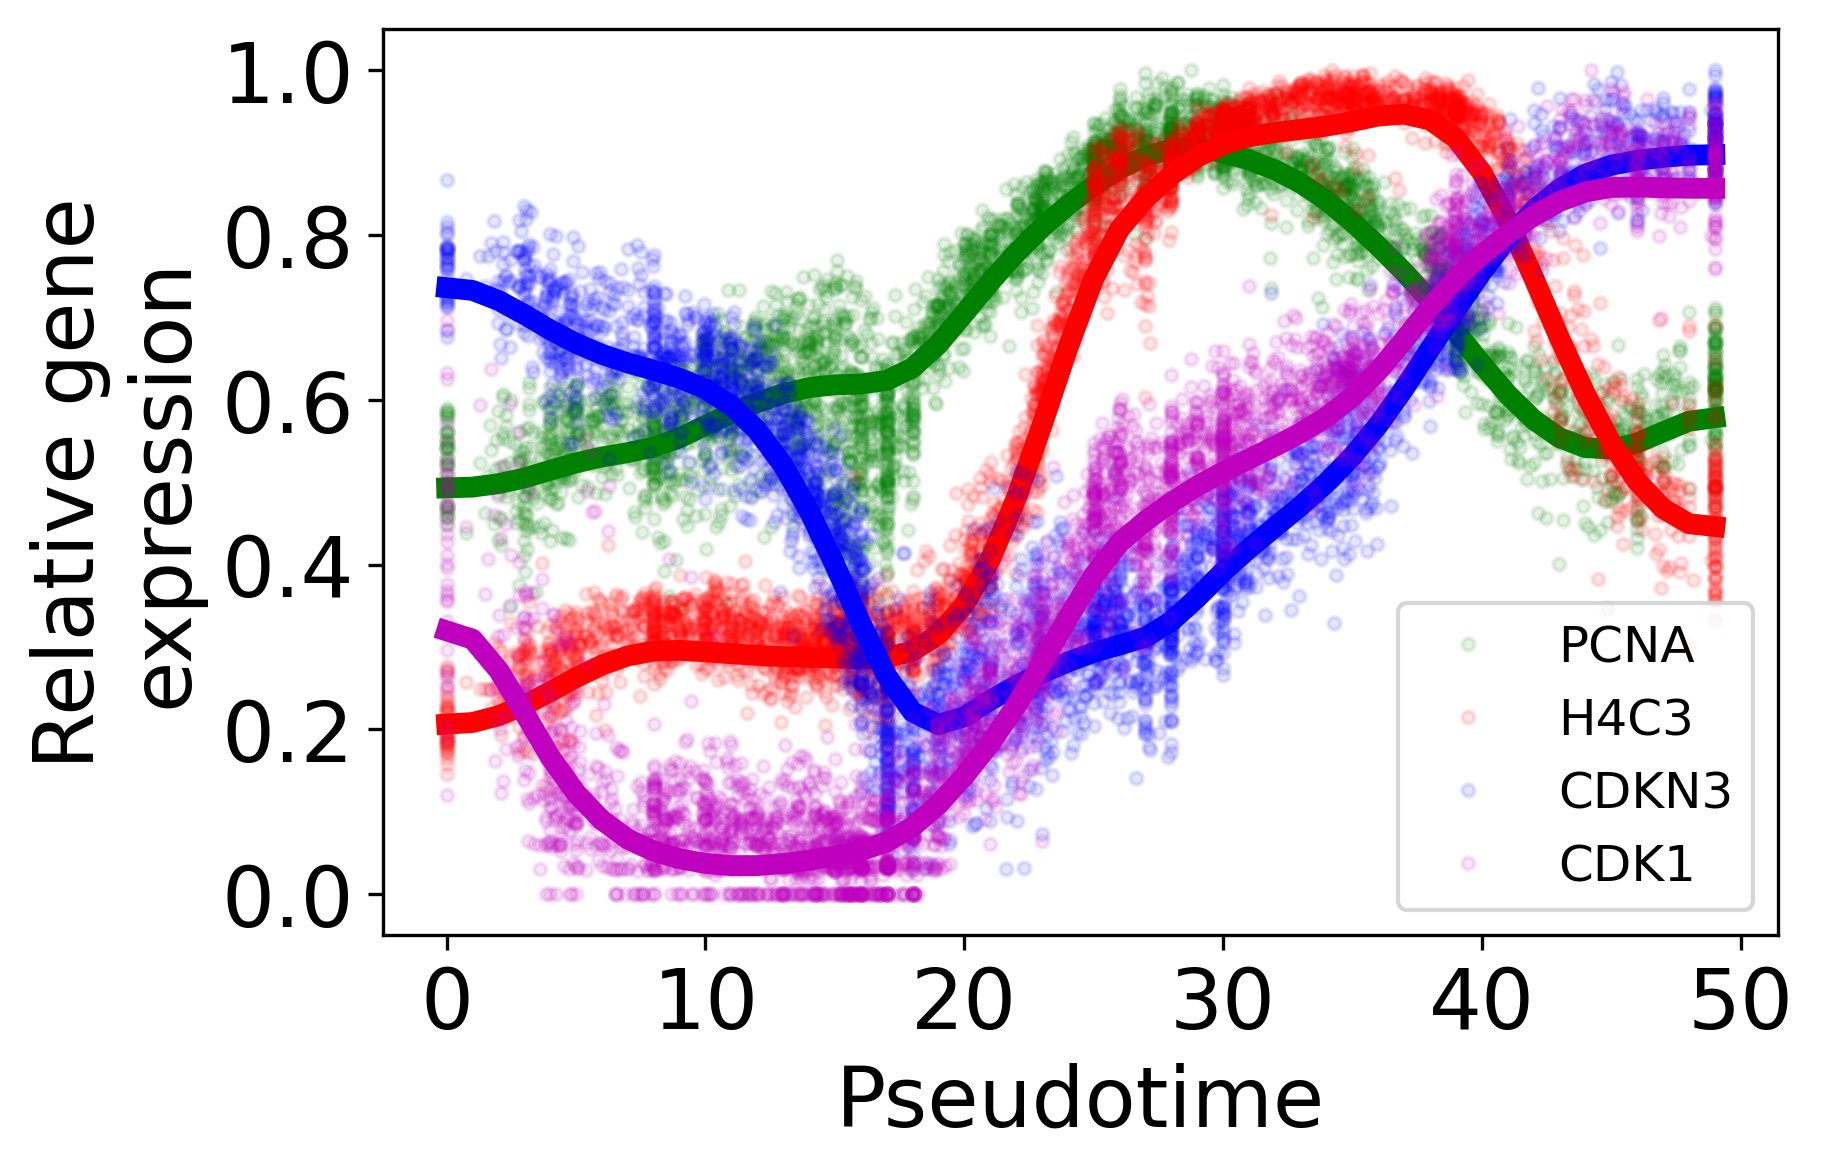

In [71]:
# Plot four selected genes

node_real_coordinates = nodep@v.T+mn
adata_nodes = anndata.AnnData(X = node_real_coordinates)
adata_nodes.var_names = adata.var_names

#genes = ['CDC20','CCNB1','MCM3','H4C3','CDKN3','MKI67']
genes = ['PCNA','H4C3','CDKN3','CDK1']
colors = ['g','r','b','m']
Xsel = adata[:,genes].X
node_vals = adata_nodes[:,genes].X
plot_relative = True
if plot_relative:
    node_vals/=np.max(Xsel,axis=0)
    Xsel/=np.max(Xsel,axis=0)

for i,g in enumerate(genes):
    plt.plot(pst,Xsel[points,i],colors[i]+'.',label=genes[i],alpha=0.1)
    plt.plot(range(node_vals.shape[0]),node_vals[traj,i],colors[i]+'-',linewidth=5)
    #for k in traj[:-1]:
    #    v1 = node_vals[traj[k],i]
    #    v2 = node_vals[traj[k+1],i]
    #    plt.plot([k,k+1],[v1,v2],colors[i]+'-')
plt.ylabel('Relative gene\nexpression',fontsize=20)
plt.xlabel('Pseudotime',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()

(50, 30)


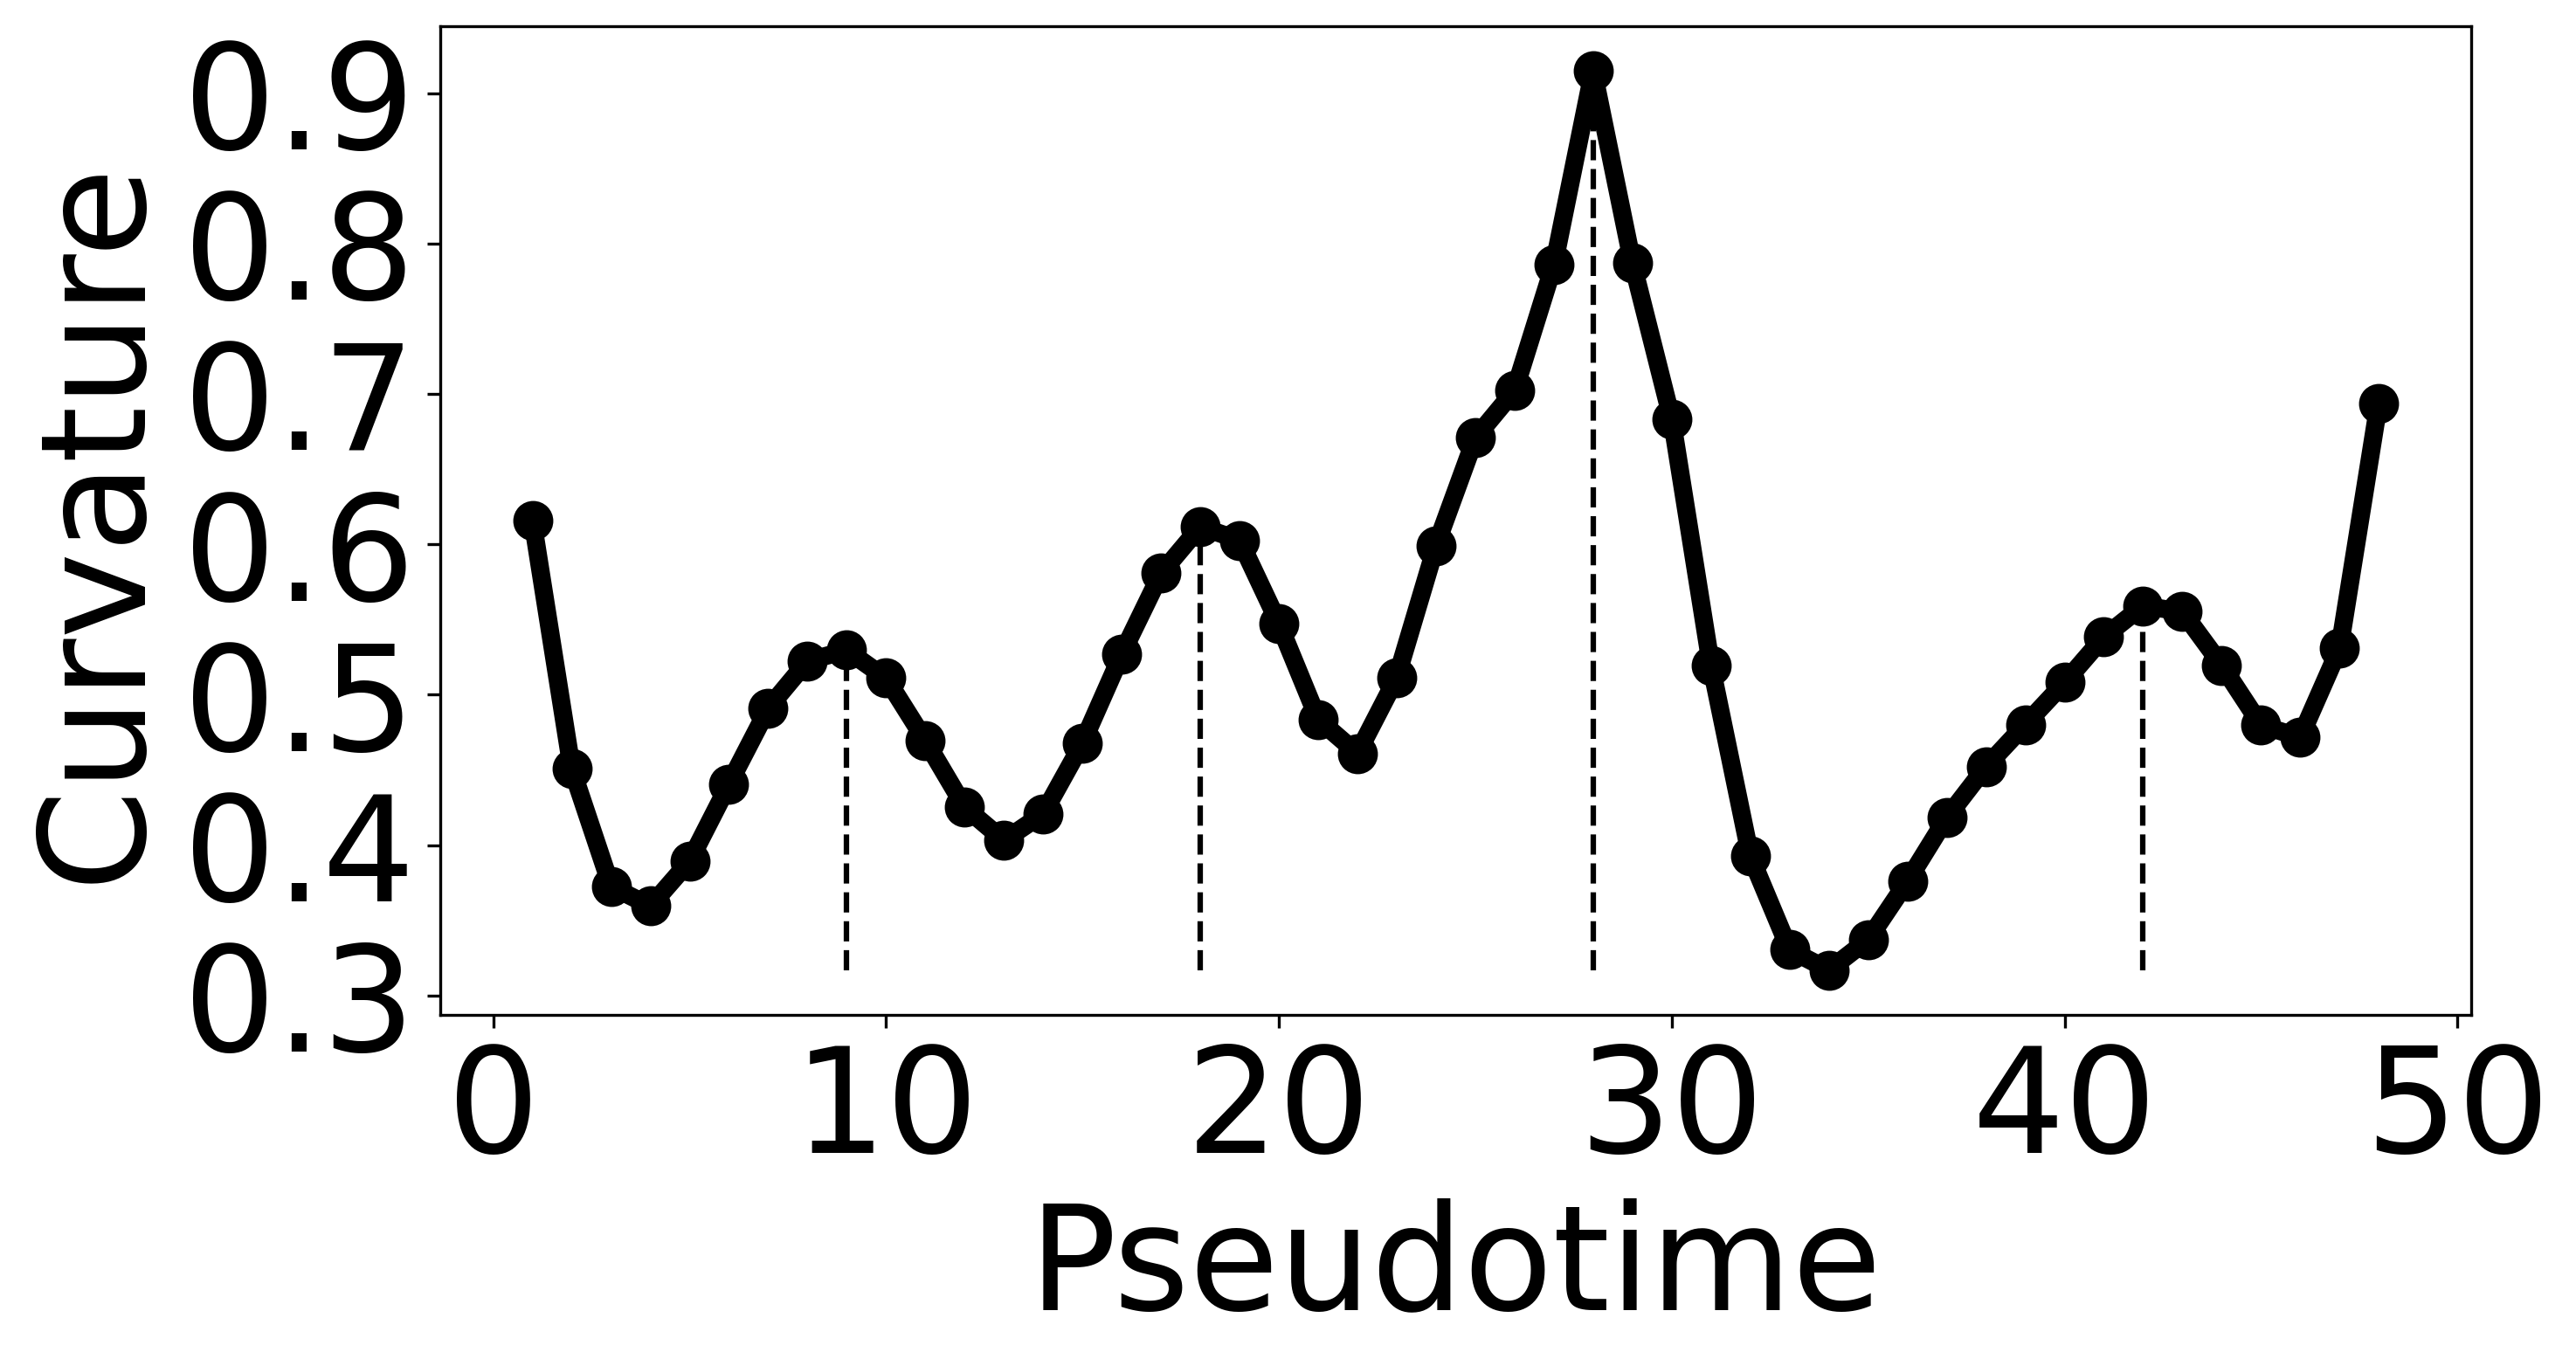

In [75]:
# Curvature analysis

max_dimension = nodep.shape[1]
#max_dimension = 10
scale = 1

#egr = egr_ic
#traj = traj_ic
gr = egr[0]

curv = np.zeros(len(traj))
nodep = gr['NodePositions']
reduced_dimension = np.min([nodep.shape[1],max_dimension])
x_curv, curv, splines = calc_curvature(nodep[traj,0:reduced_dimension],smoothing_factor=12)
x_curv = x_curv[1:-1]
curv = curv[1:-1]
#curv = (curv-np.min(curv))/(np.max(curv)-np.min(curv))
curvature_peaks = np.array(find_peaks(curv))[0]

plt.figure(figsize=(10,5))

#for i in range(max_dimension):
#    plt.plot(range(nodep.shape[0]),nodep[traj,i],'-',alpha=0.2,linewidth=5)

#plt.plot(pst,adata.obs['IC'+str(idx_g1s+1)][points],'r.',label='G1S')
#plt.plot(pst,adata.obs['IC'+str(idx_g2m+1)][points],'g.',label='G2M')
#plt.plot(pst,adata.obs['IC'+str(idx_g2m_inh+1)][points],'b.',label='G2M INH')
#plt.plot(pst,adata.obs['IC'+str(idx_histone+1)][points],'c.',label='HISTONE')
#plt.plot(x_curv,scale*curv/np.max(curv),'ko-',label='Curvature')
plt.plot(x_curv,scale*curv,'ko-',label='Curvature',linewidth=5,markersize=10)
for i in range(curvature_peaks.shape[0]):
    plt.plot([curvature_peaks[i]+1,curvature_peaks[i]+1],
             [np.min(curv),scale*curv[int(curvature_peaks[i])]],
             'k--',linewidth=1.5)
#plt.legend()
plt.xlabel('Pseudotime',fontsize=40)
plt.ylabel('Curvature',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()